In [ ]:
!pip3 install backtrader[plotting]
!pip3 install pyfolio

     |████████████████████████████████| 410 kB 27.2 MB/s 
     |████████████████████████████████| 91 kB 9.2 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88682 sha256=476bbc064d82b4ab5ece667ce3e1758be70ef64724fcae02a890112a0eca919e
  Stored in directory: /root/.cache/pip/wheels/e4/96/9b/0dfff5453e702fd780a099b7c850521099c5ec0dfafae189f9
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39779 sha256=bbf6a5984db9414389b97cac39a29baadd7bcc52f6270c4911743218d57a9eec
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
import backtrader as bt
import pandas as pd
import numpy as np
import math 
import statistics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as st
import datetime as dt
import pyfolio as pf
from scipy.optimize import minimize

from sklearn.linear_model import LinearRegression

# Connect to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


Mounted at /content/drive


In [ ]:
TIME_STEPS = 24 # How far in the past you want to use past data as features
TARGET_TIME_STEPS = 12 # How far in the future you want to make predictions
#INP_COLS = [0, 1, 2, 3, 4]
INP_COLS = [1]
OUT_COL = 1

# Buy and Hold

In [ ]:
class buy_and_hold_strategy(bt.Strategy):
    params = dict(log_period = 1)

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    def start(self):
        self.order = None 

    def __init__(self):
        self.data_close = self.datas[0].close
        self.log_return_list = []
        self.init_price = 0 
        self.current_f = 0
        self.reg = None
        self.sxx = np.zeros((TIME_STEPS, TIME_STEPS)) # S = S_xx
        self.sigma = 0
        self.x_mean = None
        self.dof = 0
        self.n = 0

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('')
        if (len(self) == 60):
          self.order = self.order_target_percent(target = 1.00)
          self.log('%04d - Order Target Percent: %.4f' %(len(self), self.current_f))
            


# Phase 1


## Cryptocurrency 

### USD - BTC

In [ ]:
btc_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BTC-USD.csv', index_col=0, parse_dates=True)
btc_data.dropna(inplace=True)
train_len = int(0.7 * len(btc_data))
train_len

1276

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=btc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-01-24T00:00:00, 0060 - Order Target Percent: 0.0000
2020-01-25T00:00:00, BUY EXECUTED, Price: 8445.43, Cost: 996561.28, Comm 0.00
Final Portfolio Value: 4271144.72


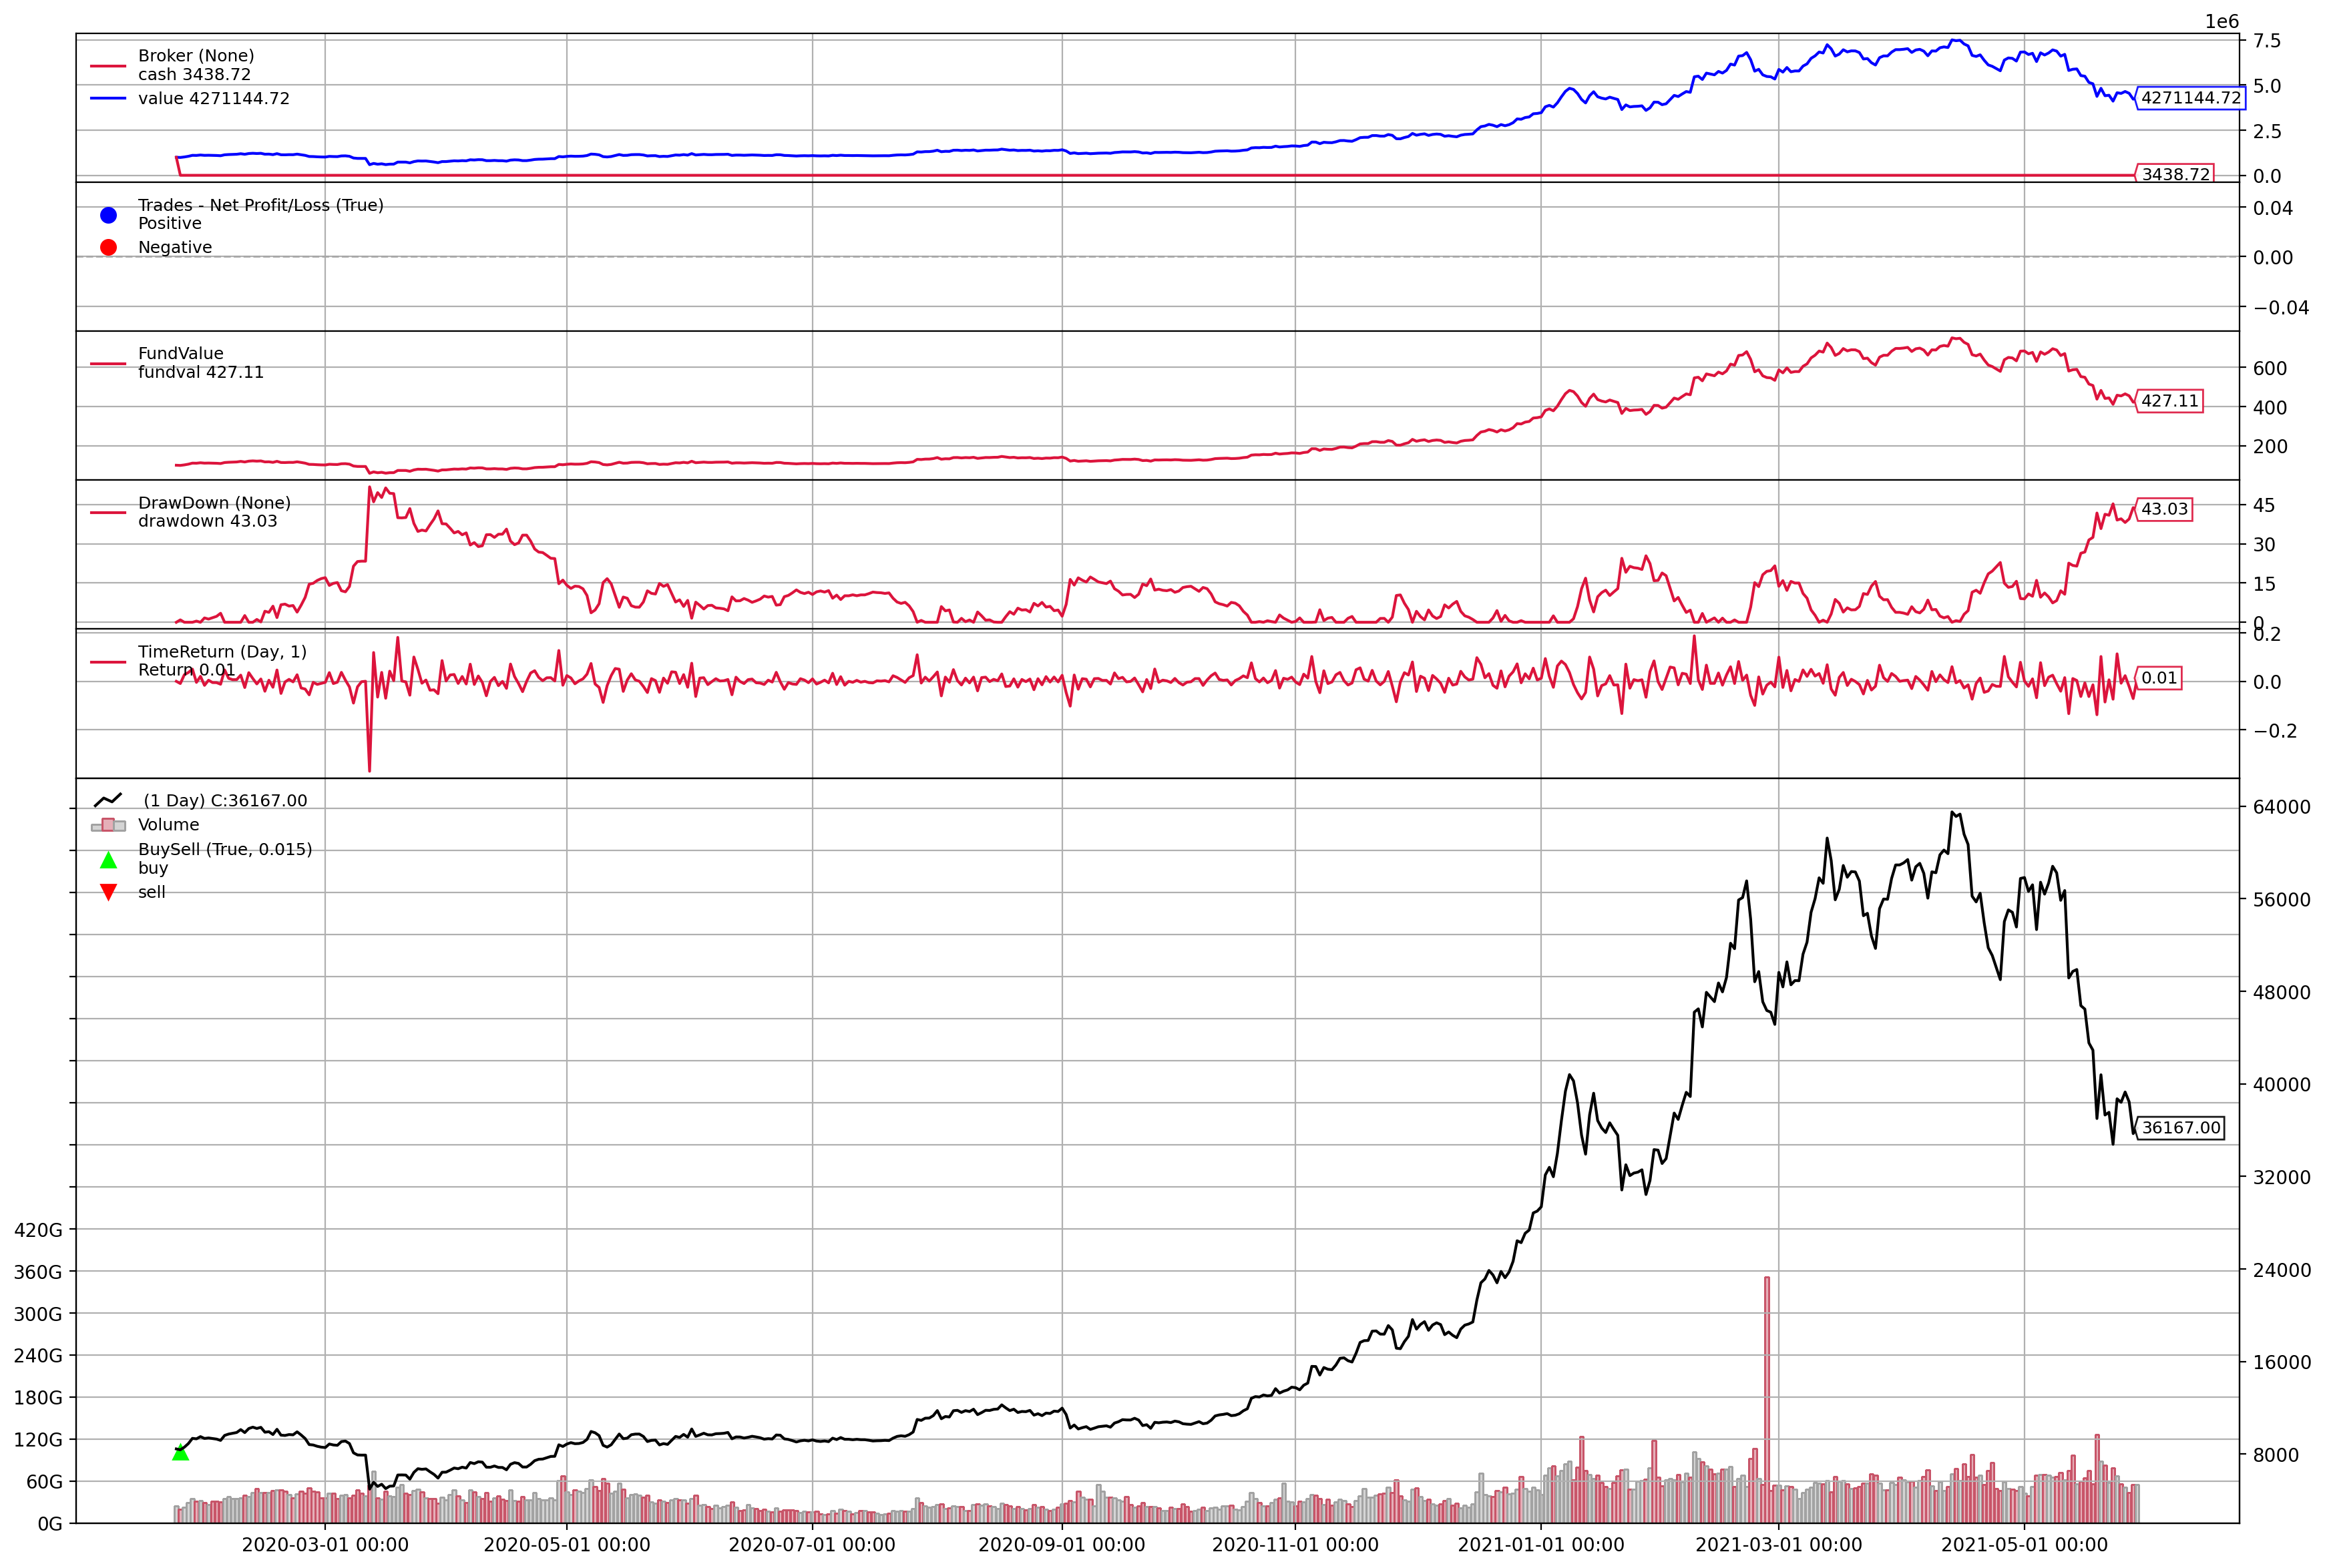

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2020, 1, 24), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-1-24',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - ETH

In [ ]:
eth_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ETH-USD.csv', index_col=0, parse_dates=True)
eth_data.dropna(inplace=True)
train_len = int(0.7 * len(eth_data))
train_len

1276

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=eth_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-01-24T00:00:00, 0060 - Order Target Percent: 0.0000
2020-01-25T00:00:00, BUY EXECUTED, Price: 163.05, Cost: 999992.87, Comm 0.00
Final Portfolio Value: 15495052.59


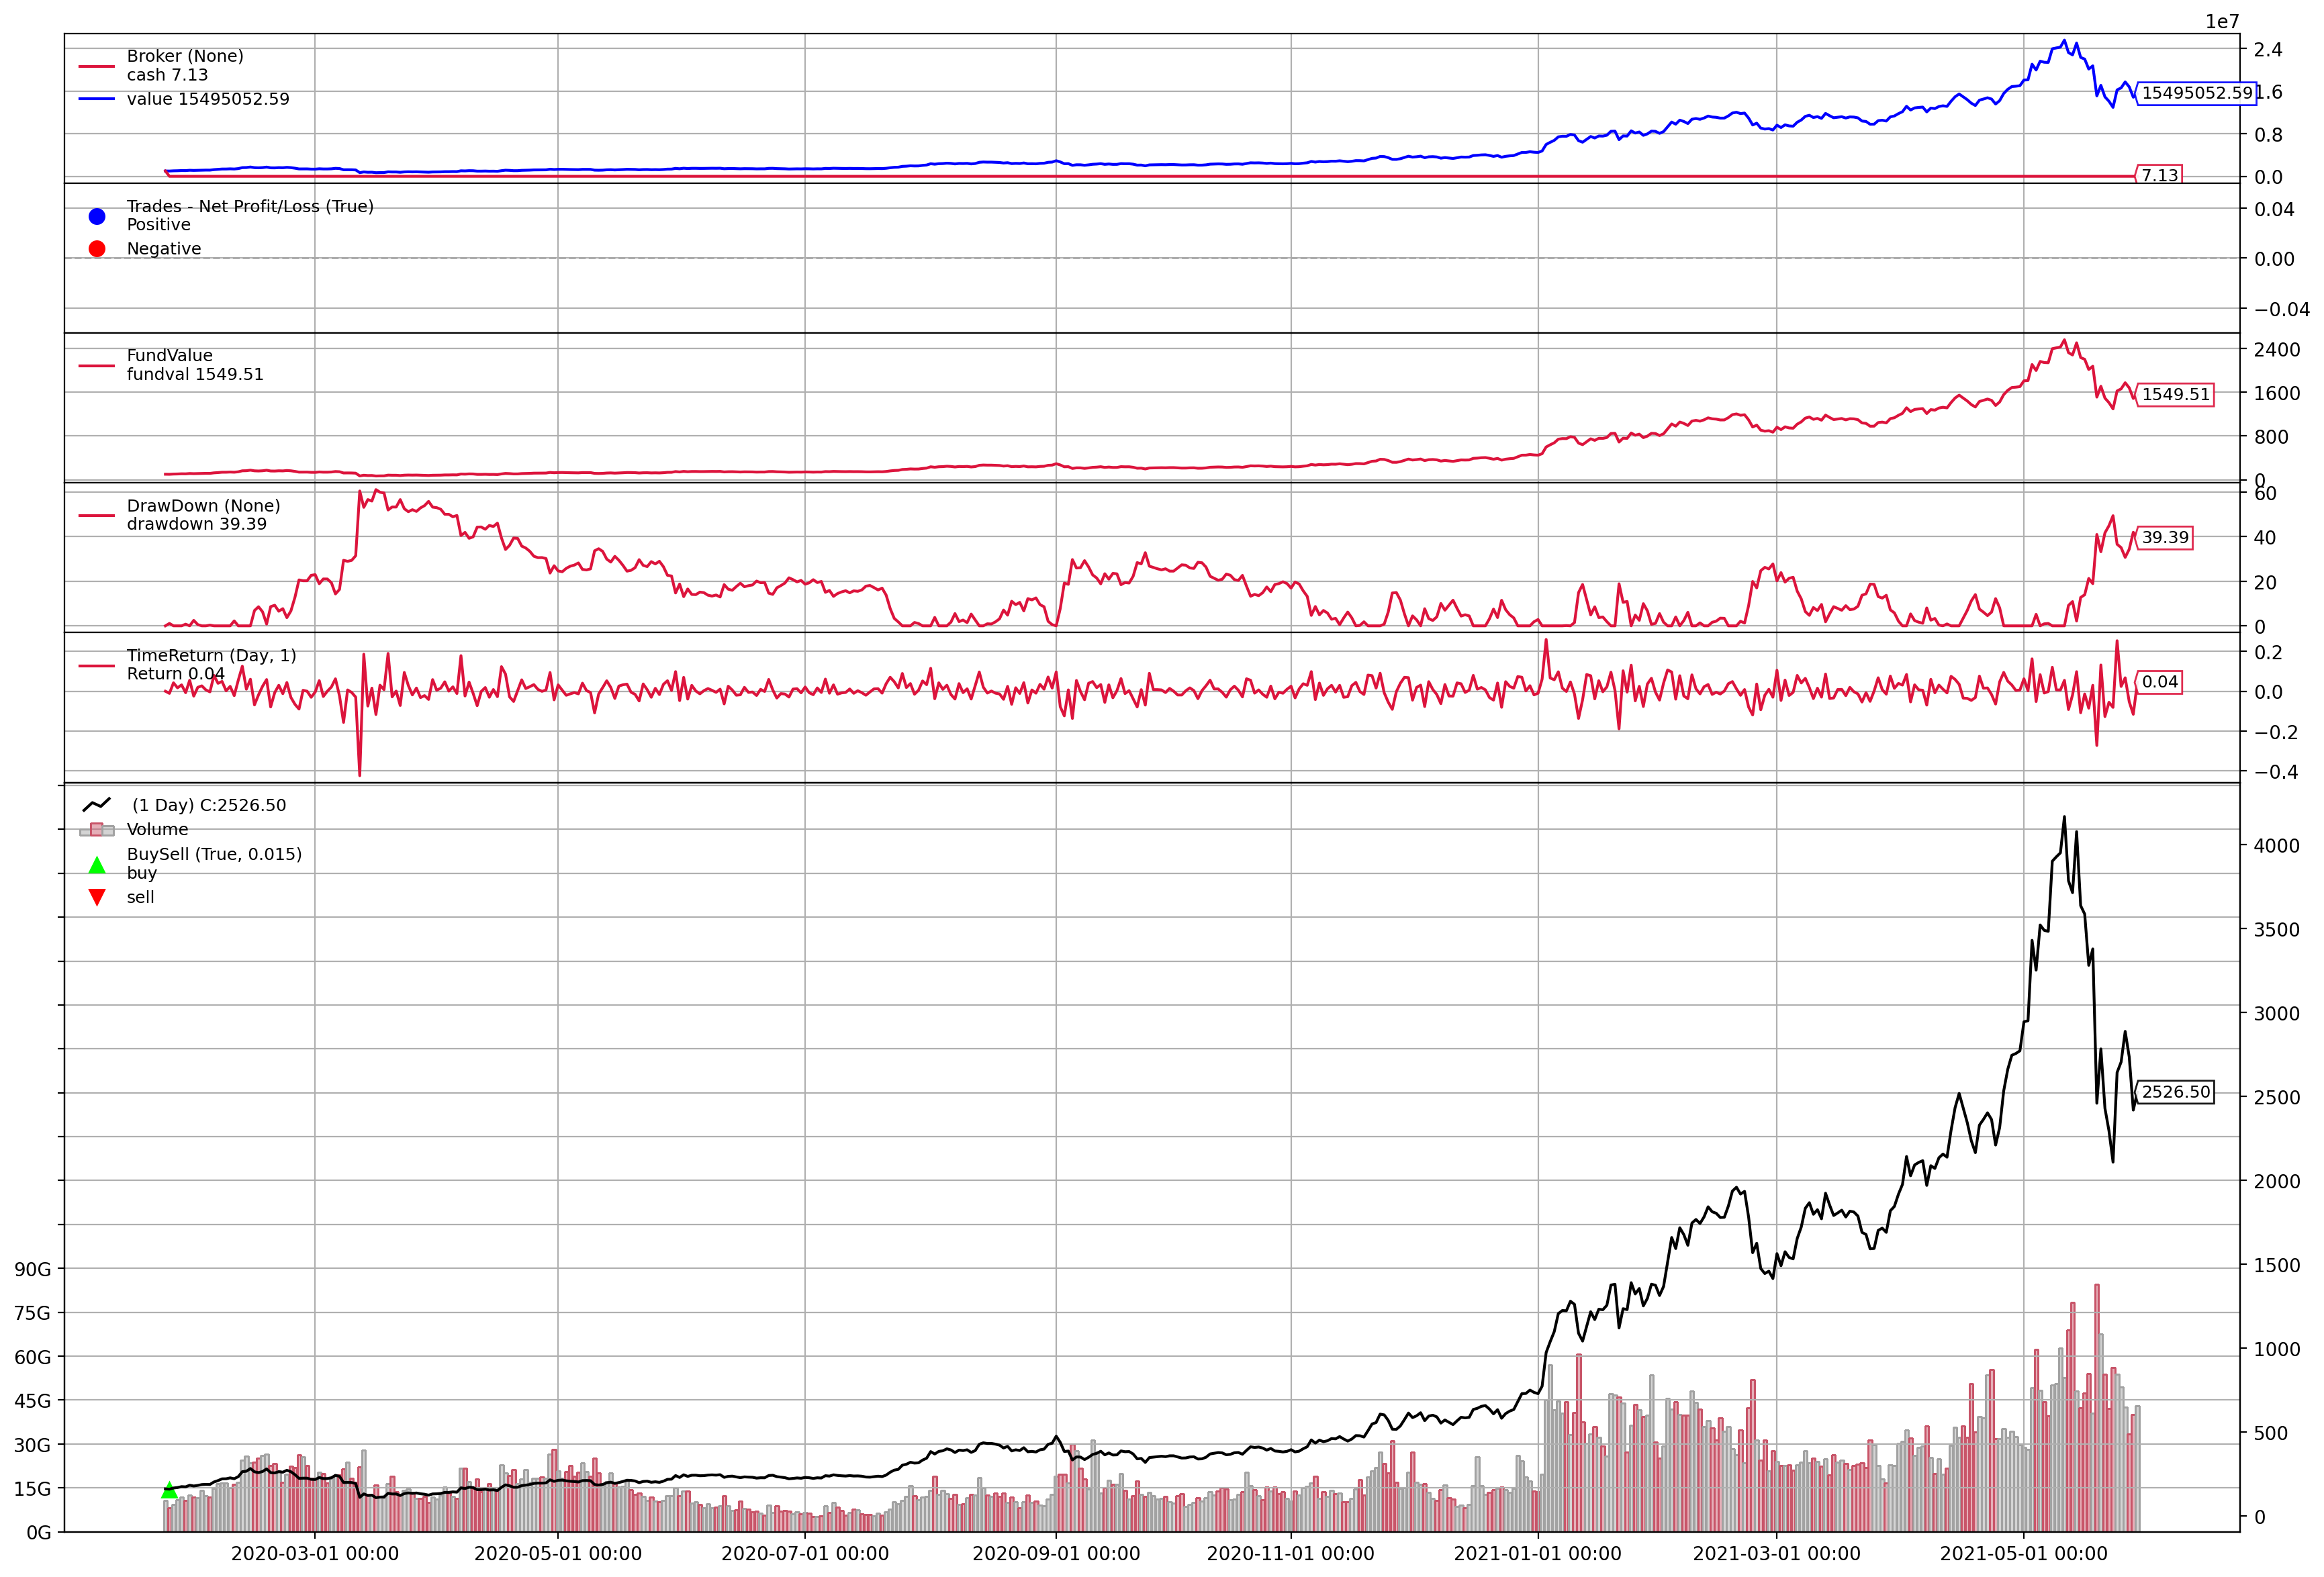

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2020, 1, 24), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-1-24',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - DOGE

In [ ]:
doge_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/DOGE-USD.csv', index_col=0, parse_dates=True)
doge_data.dropna(inplace=True)
train_len = int(0.7 * len(doge_data))
train_len

1276

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=doge_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-01-24T00:00:00, 0060 - Order Target Percent: 0.0000
2020-01-25T00:00:00, BUY EXECUTED, Price: 0.00, Cost: 1000000.00, Comm 0.00
Final Portfolio Value: 136438927.92


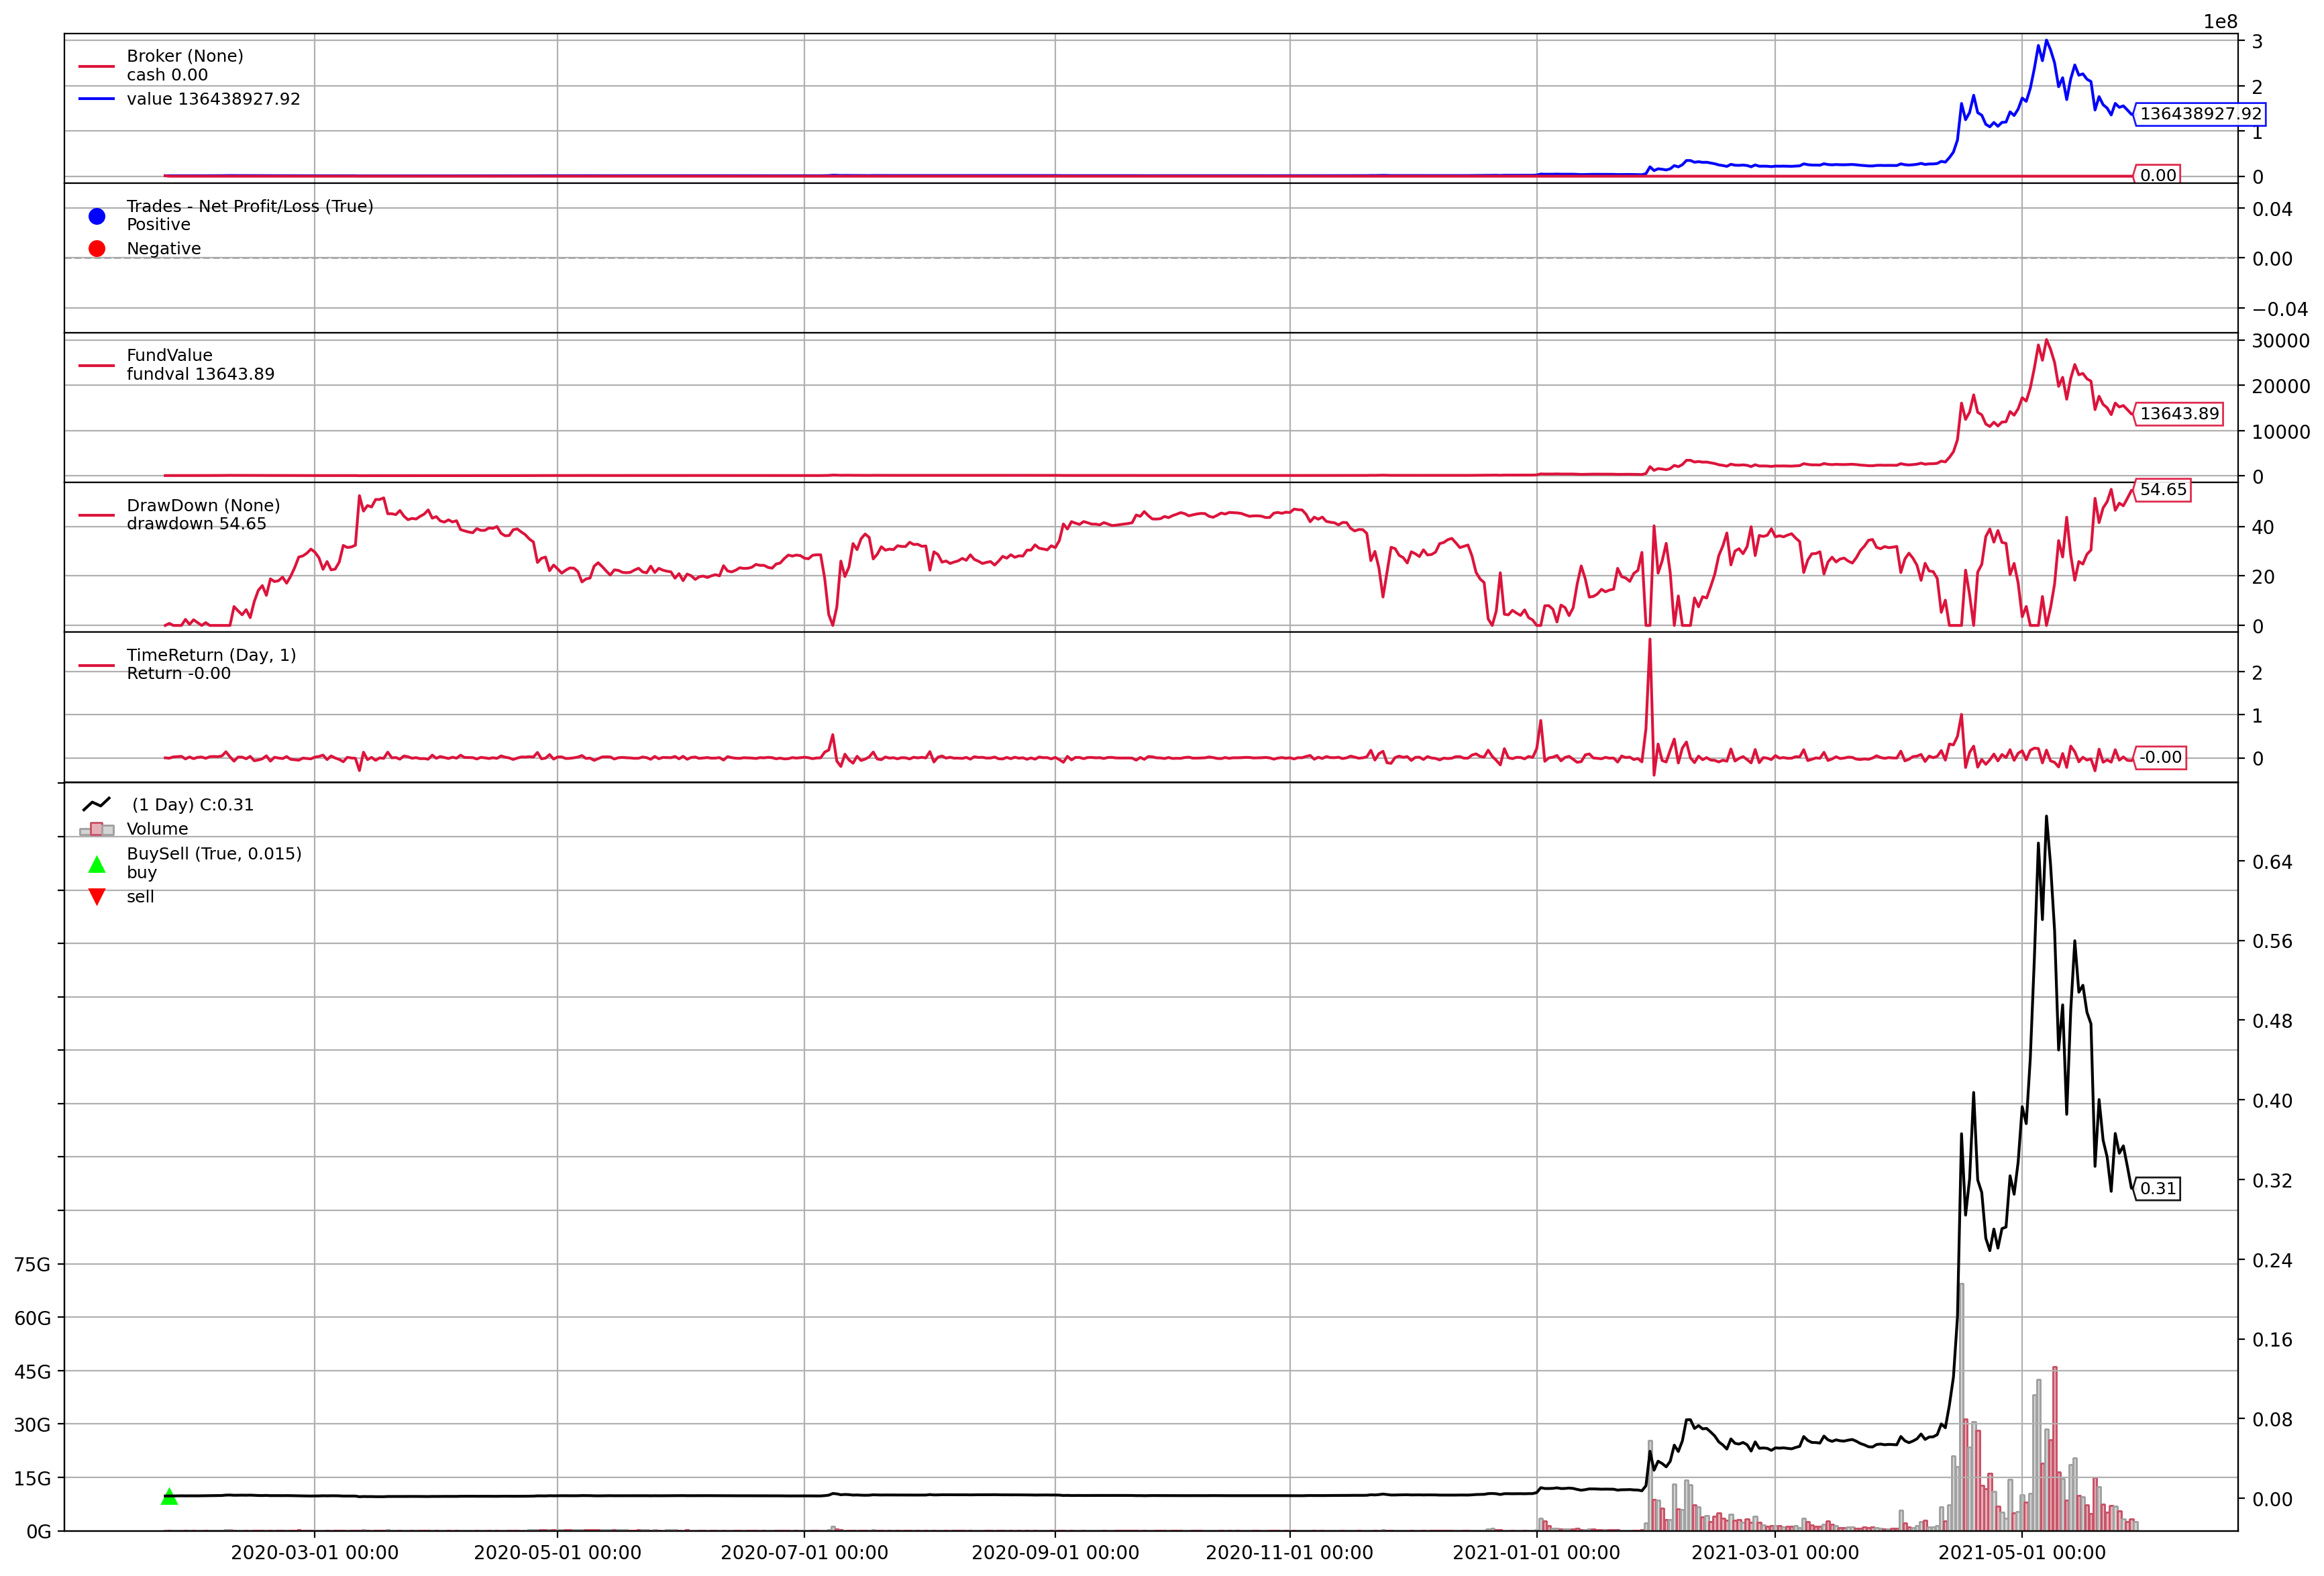

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2020, 1, 24), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-1-24',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - XRP

In [ ]:
xrp_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/XRP-USD.csv', index_col=0, parse_dates=True)
xrp_data.dropna(inplace=True)
train_len = int(0.7 * len(xrp_data))
train_len

1276

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=xrp_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-01-24T00:00:00, 0060 - Order Target Percent: 0.0000
2020-01-25T00:00:00, BUY EXECUTED, Price: 0.22, Cost: 999999.86, Comm 0.00
Final Portfolio Value: 4031702.28


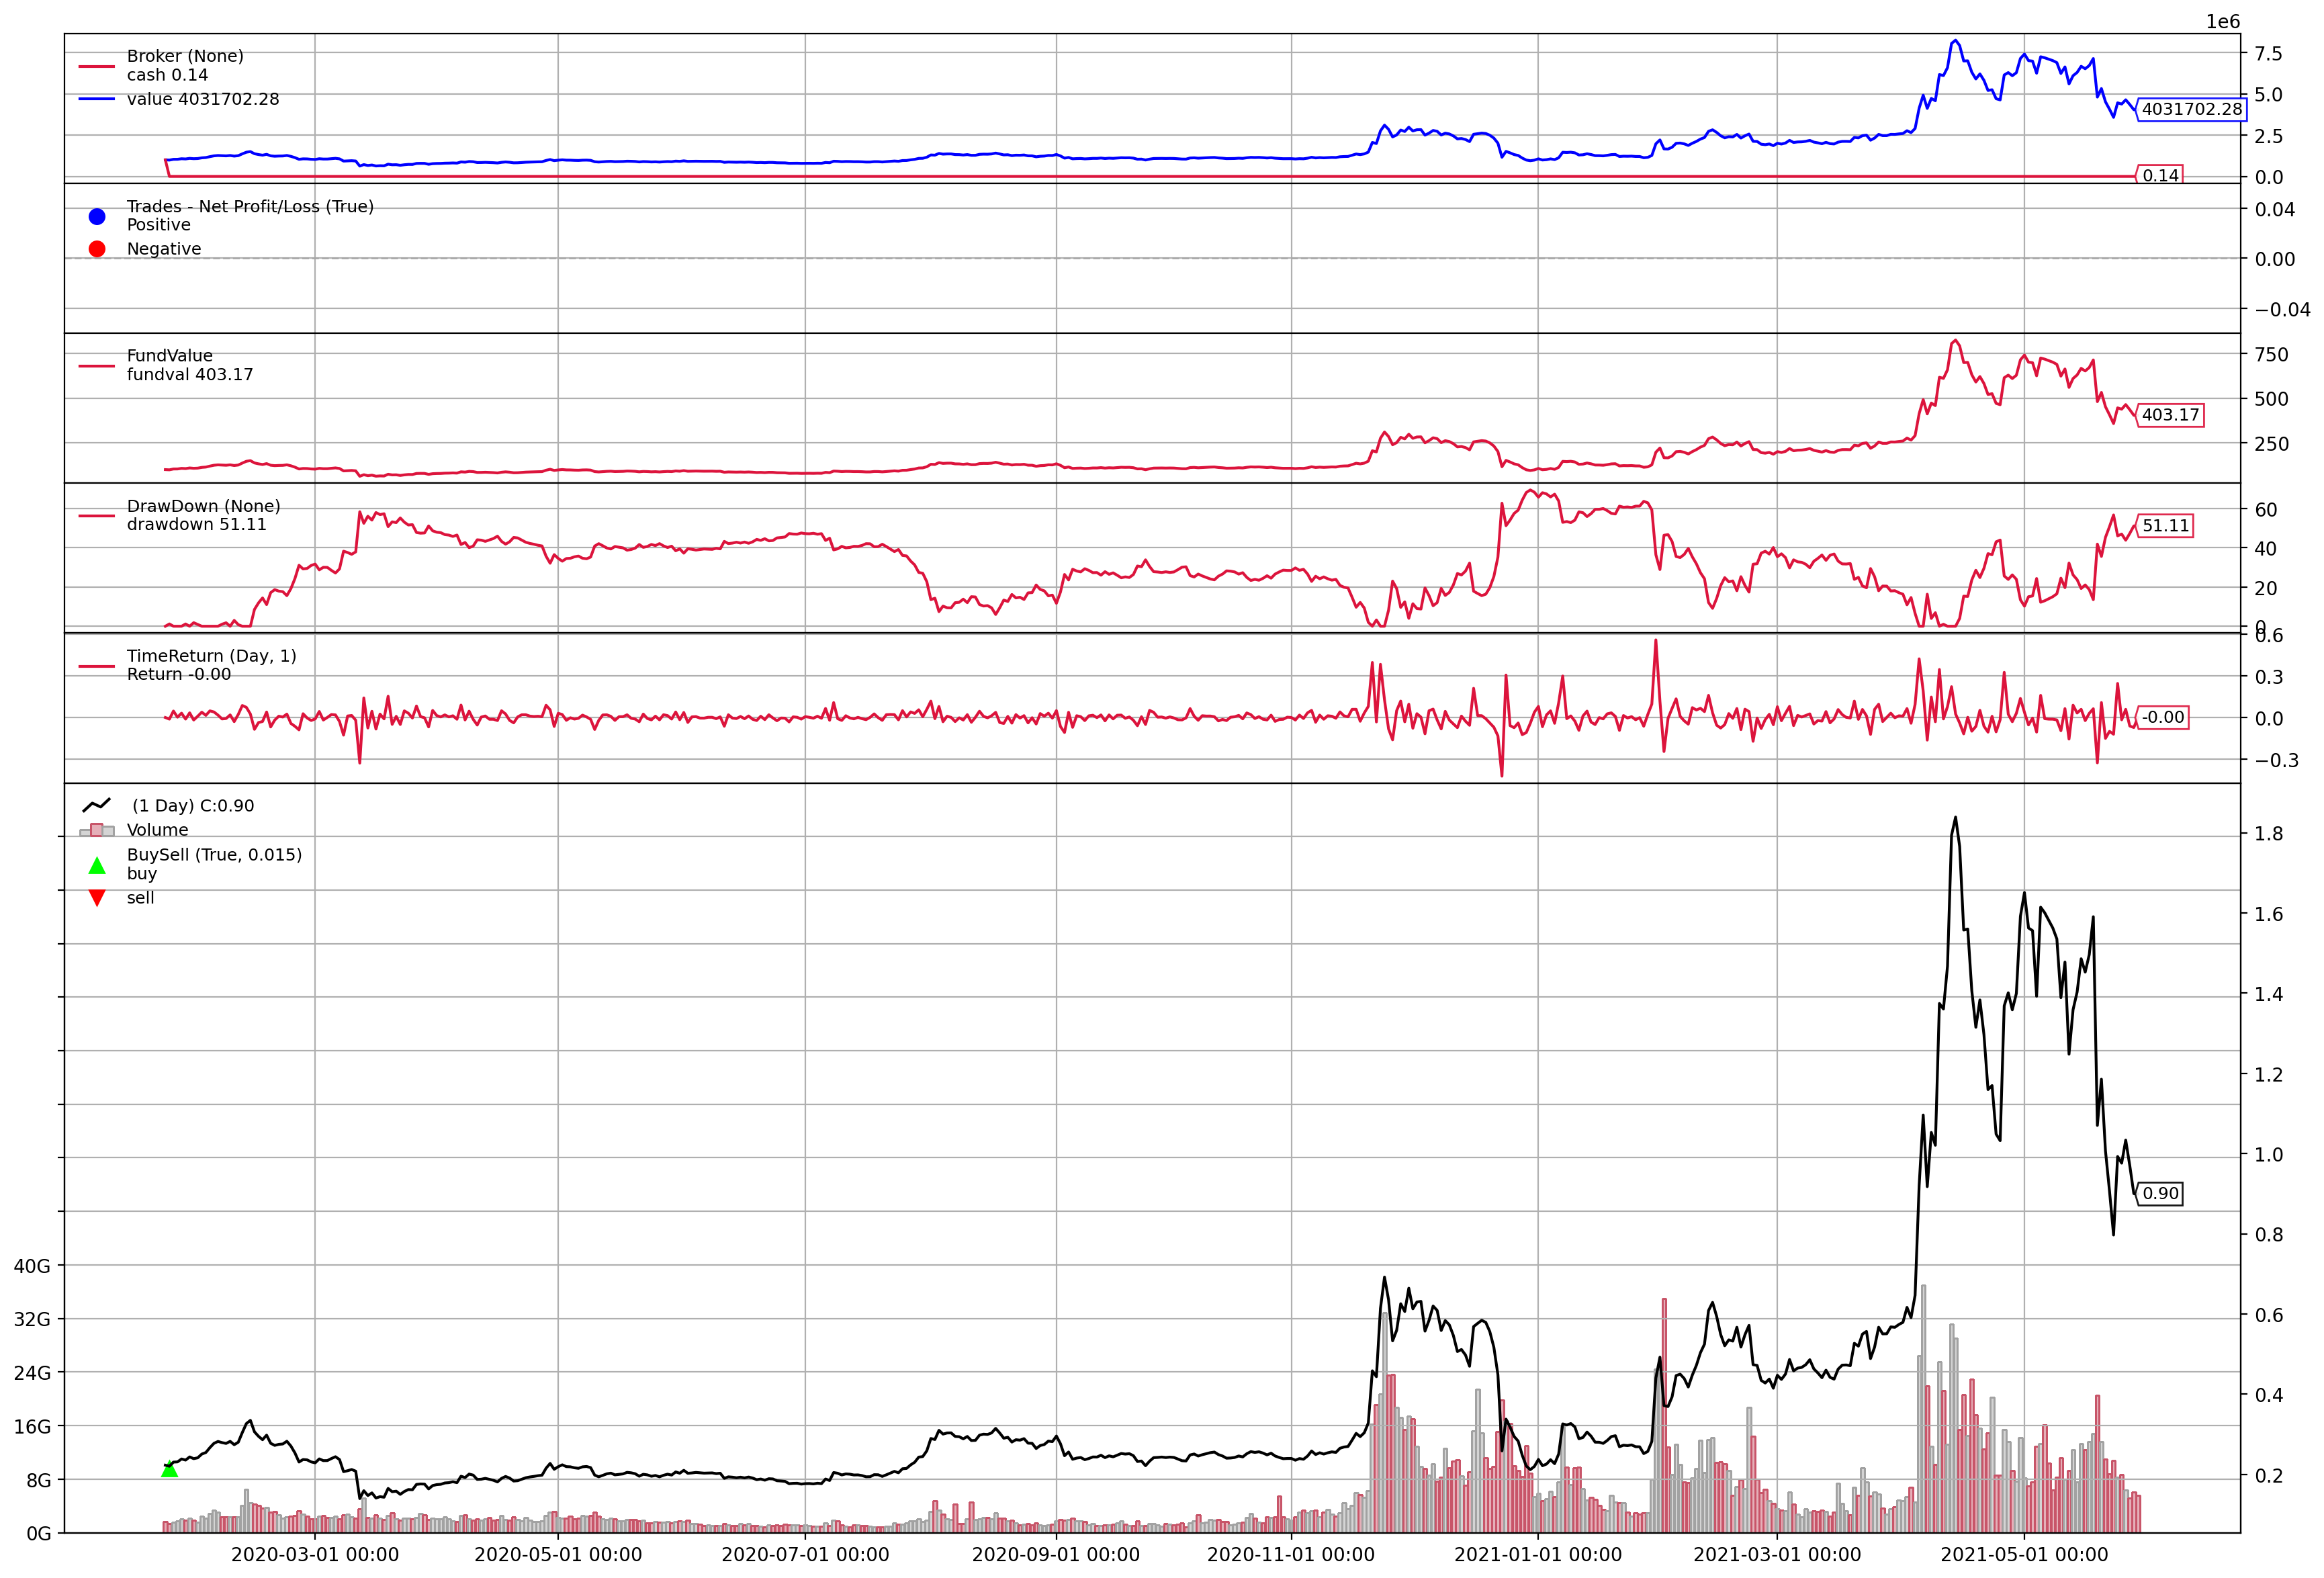

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2020, 1, 24), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-1-24',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - LTC

In [ ]:
ltc_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/LTC-USD.csv', index_col=0, parse_dates=True)
ltc_data.dropna(inplace=True)
train_len = int(0.7 * len(ltc_data))
train_len

1276

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=ltc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-01-24T00:00:00, 0060 - Order Target Percent: 0.0000
2020-01-25T00:00:00, BUY EXECUTED, Price: 54.53, Cost: 999949.40, Comm 0.00
Final Portfolio Value: 3315736.44


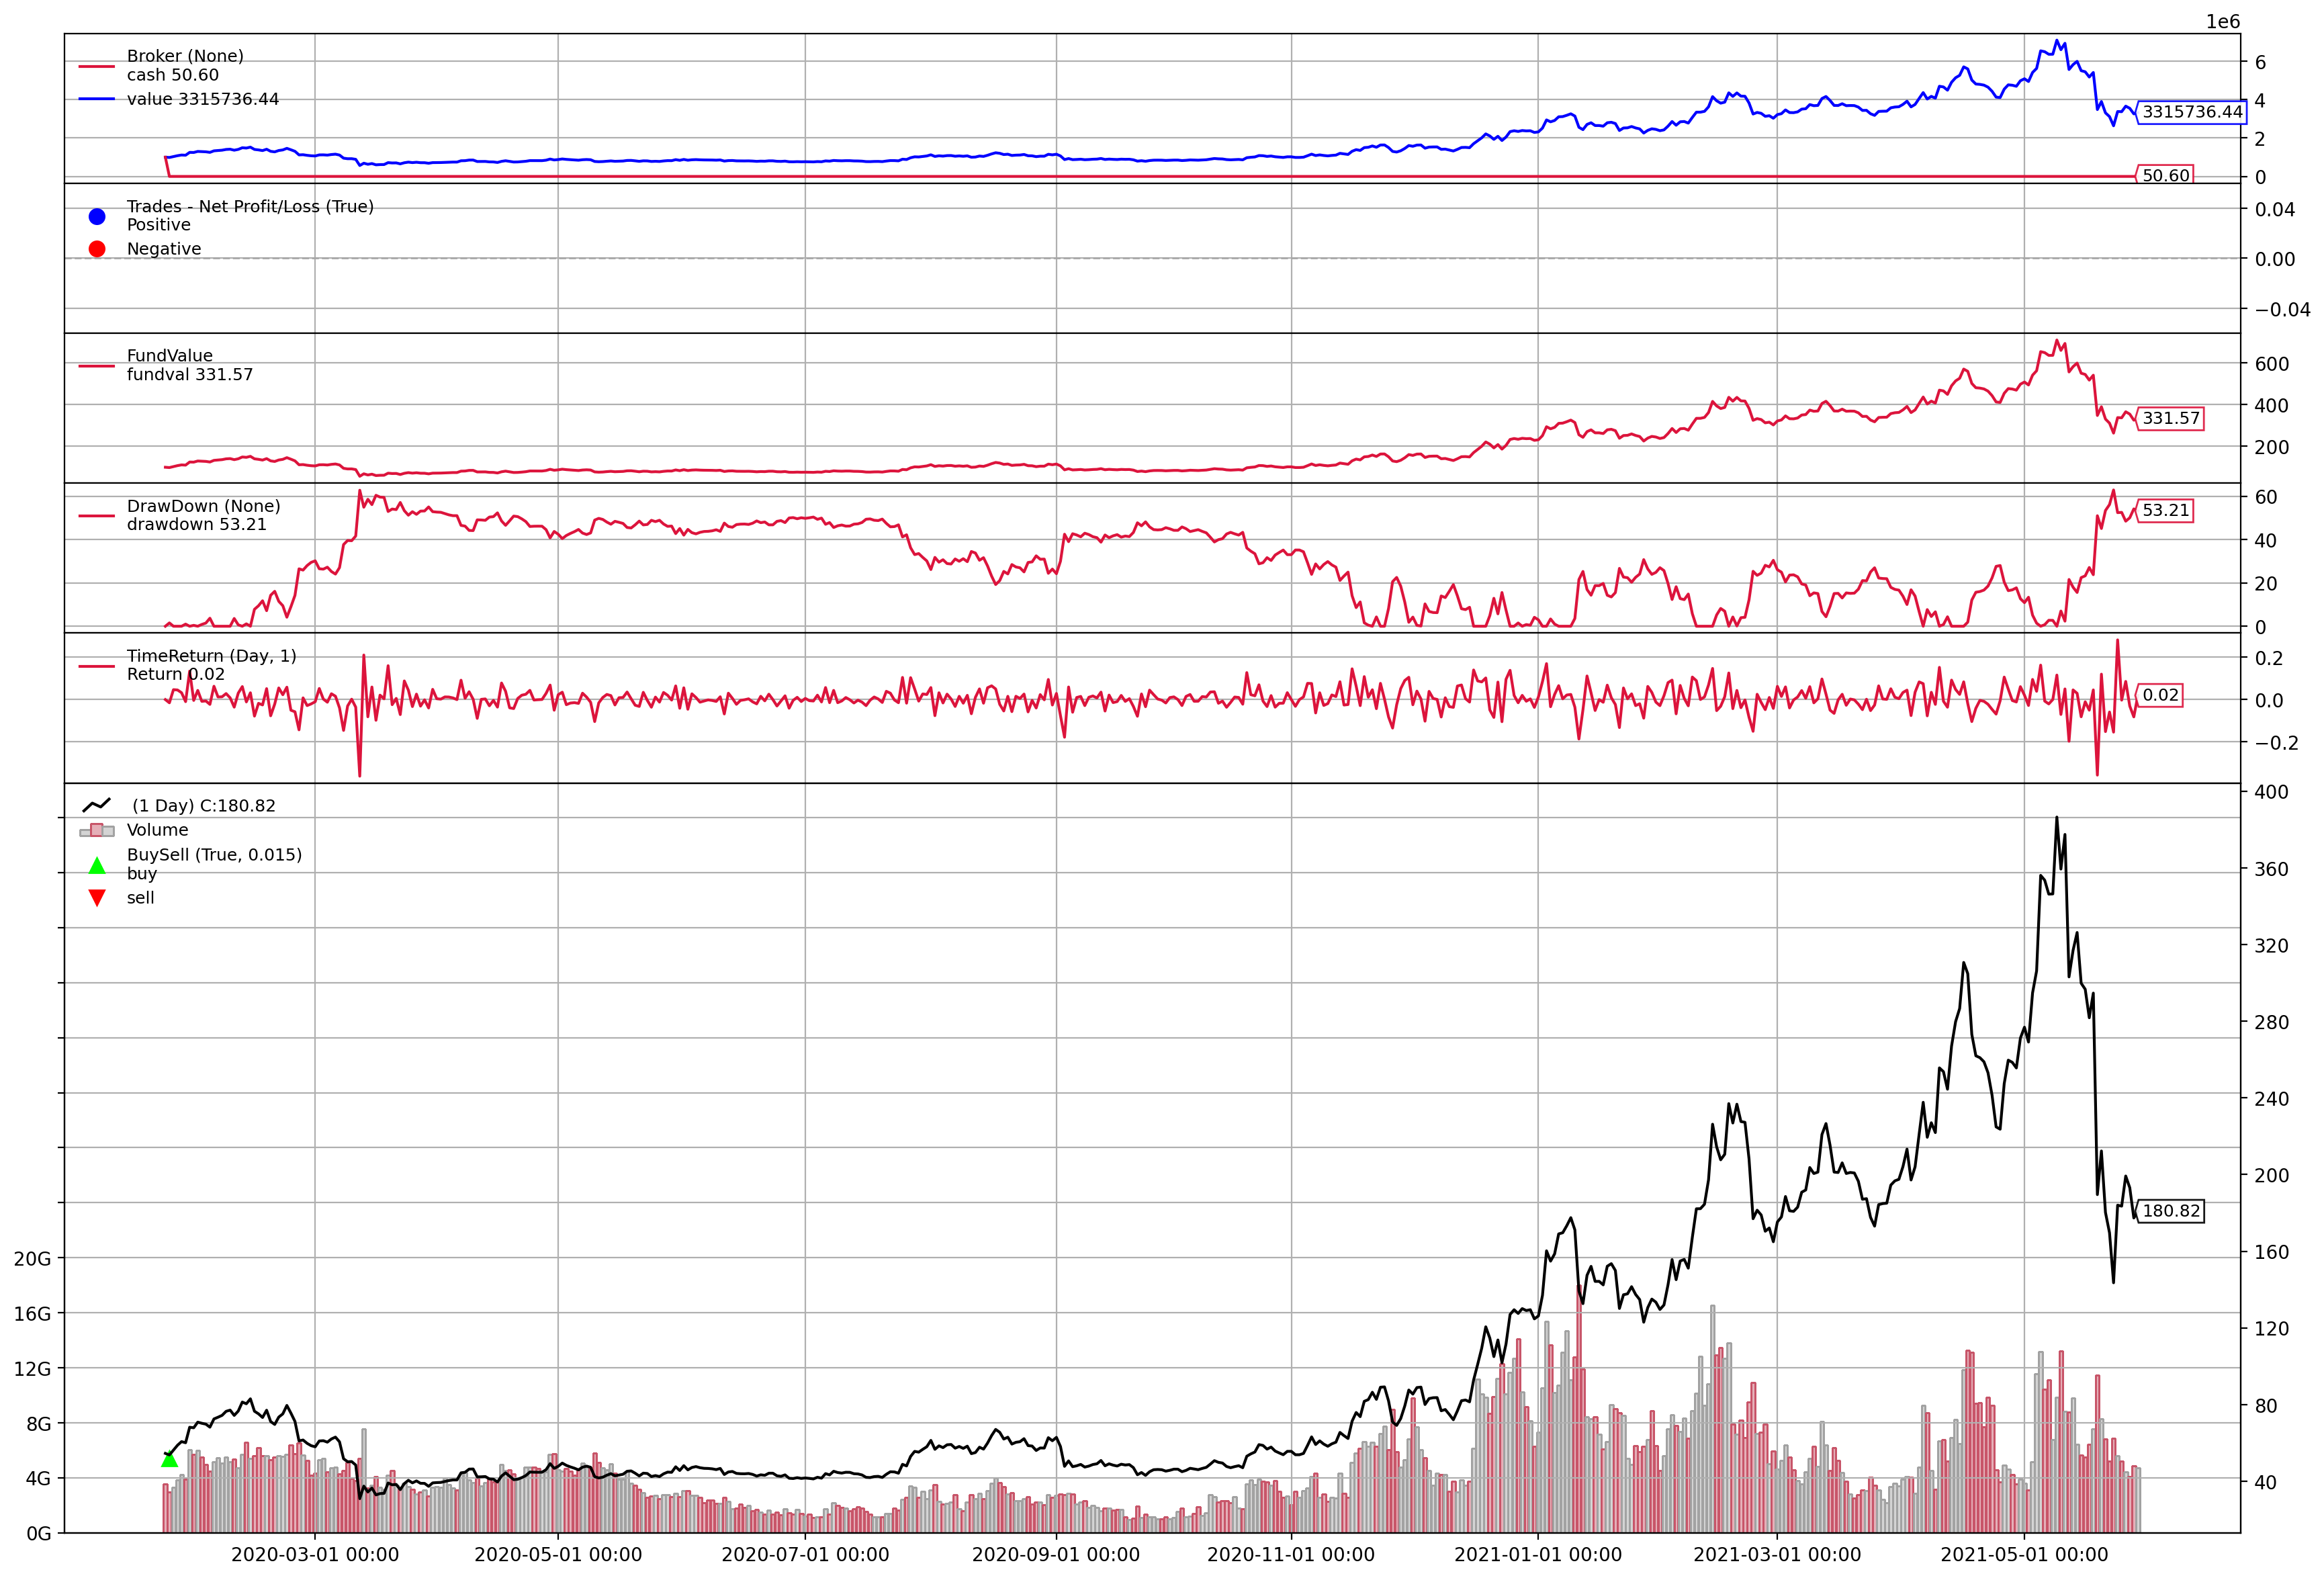

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2020, 1, 24), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-1-24',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - BCH

In [ ]:
bch_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BCH-USD.csv', index_col=0, parse_dates=True)
bch_data.dropna(inplace=True)
train_len = int(0.7 * len(bch_data))
train_len

982

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=bch_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-05-30T00:00:00, 0060 - Order Target Percent: 0.0000
2020-05-31T00:00:00, BUY EXECUTED, Price: 251.30, Cost: 999920.83, Comm 0.00
Final Portfolio Value: 2751194.35


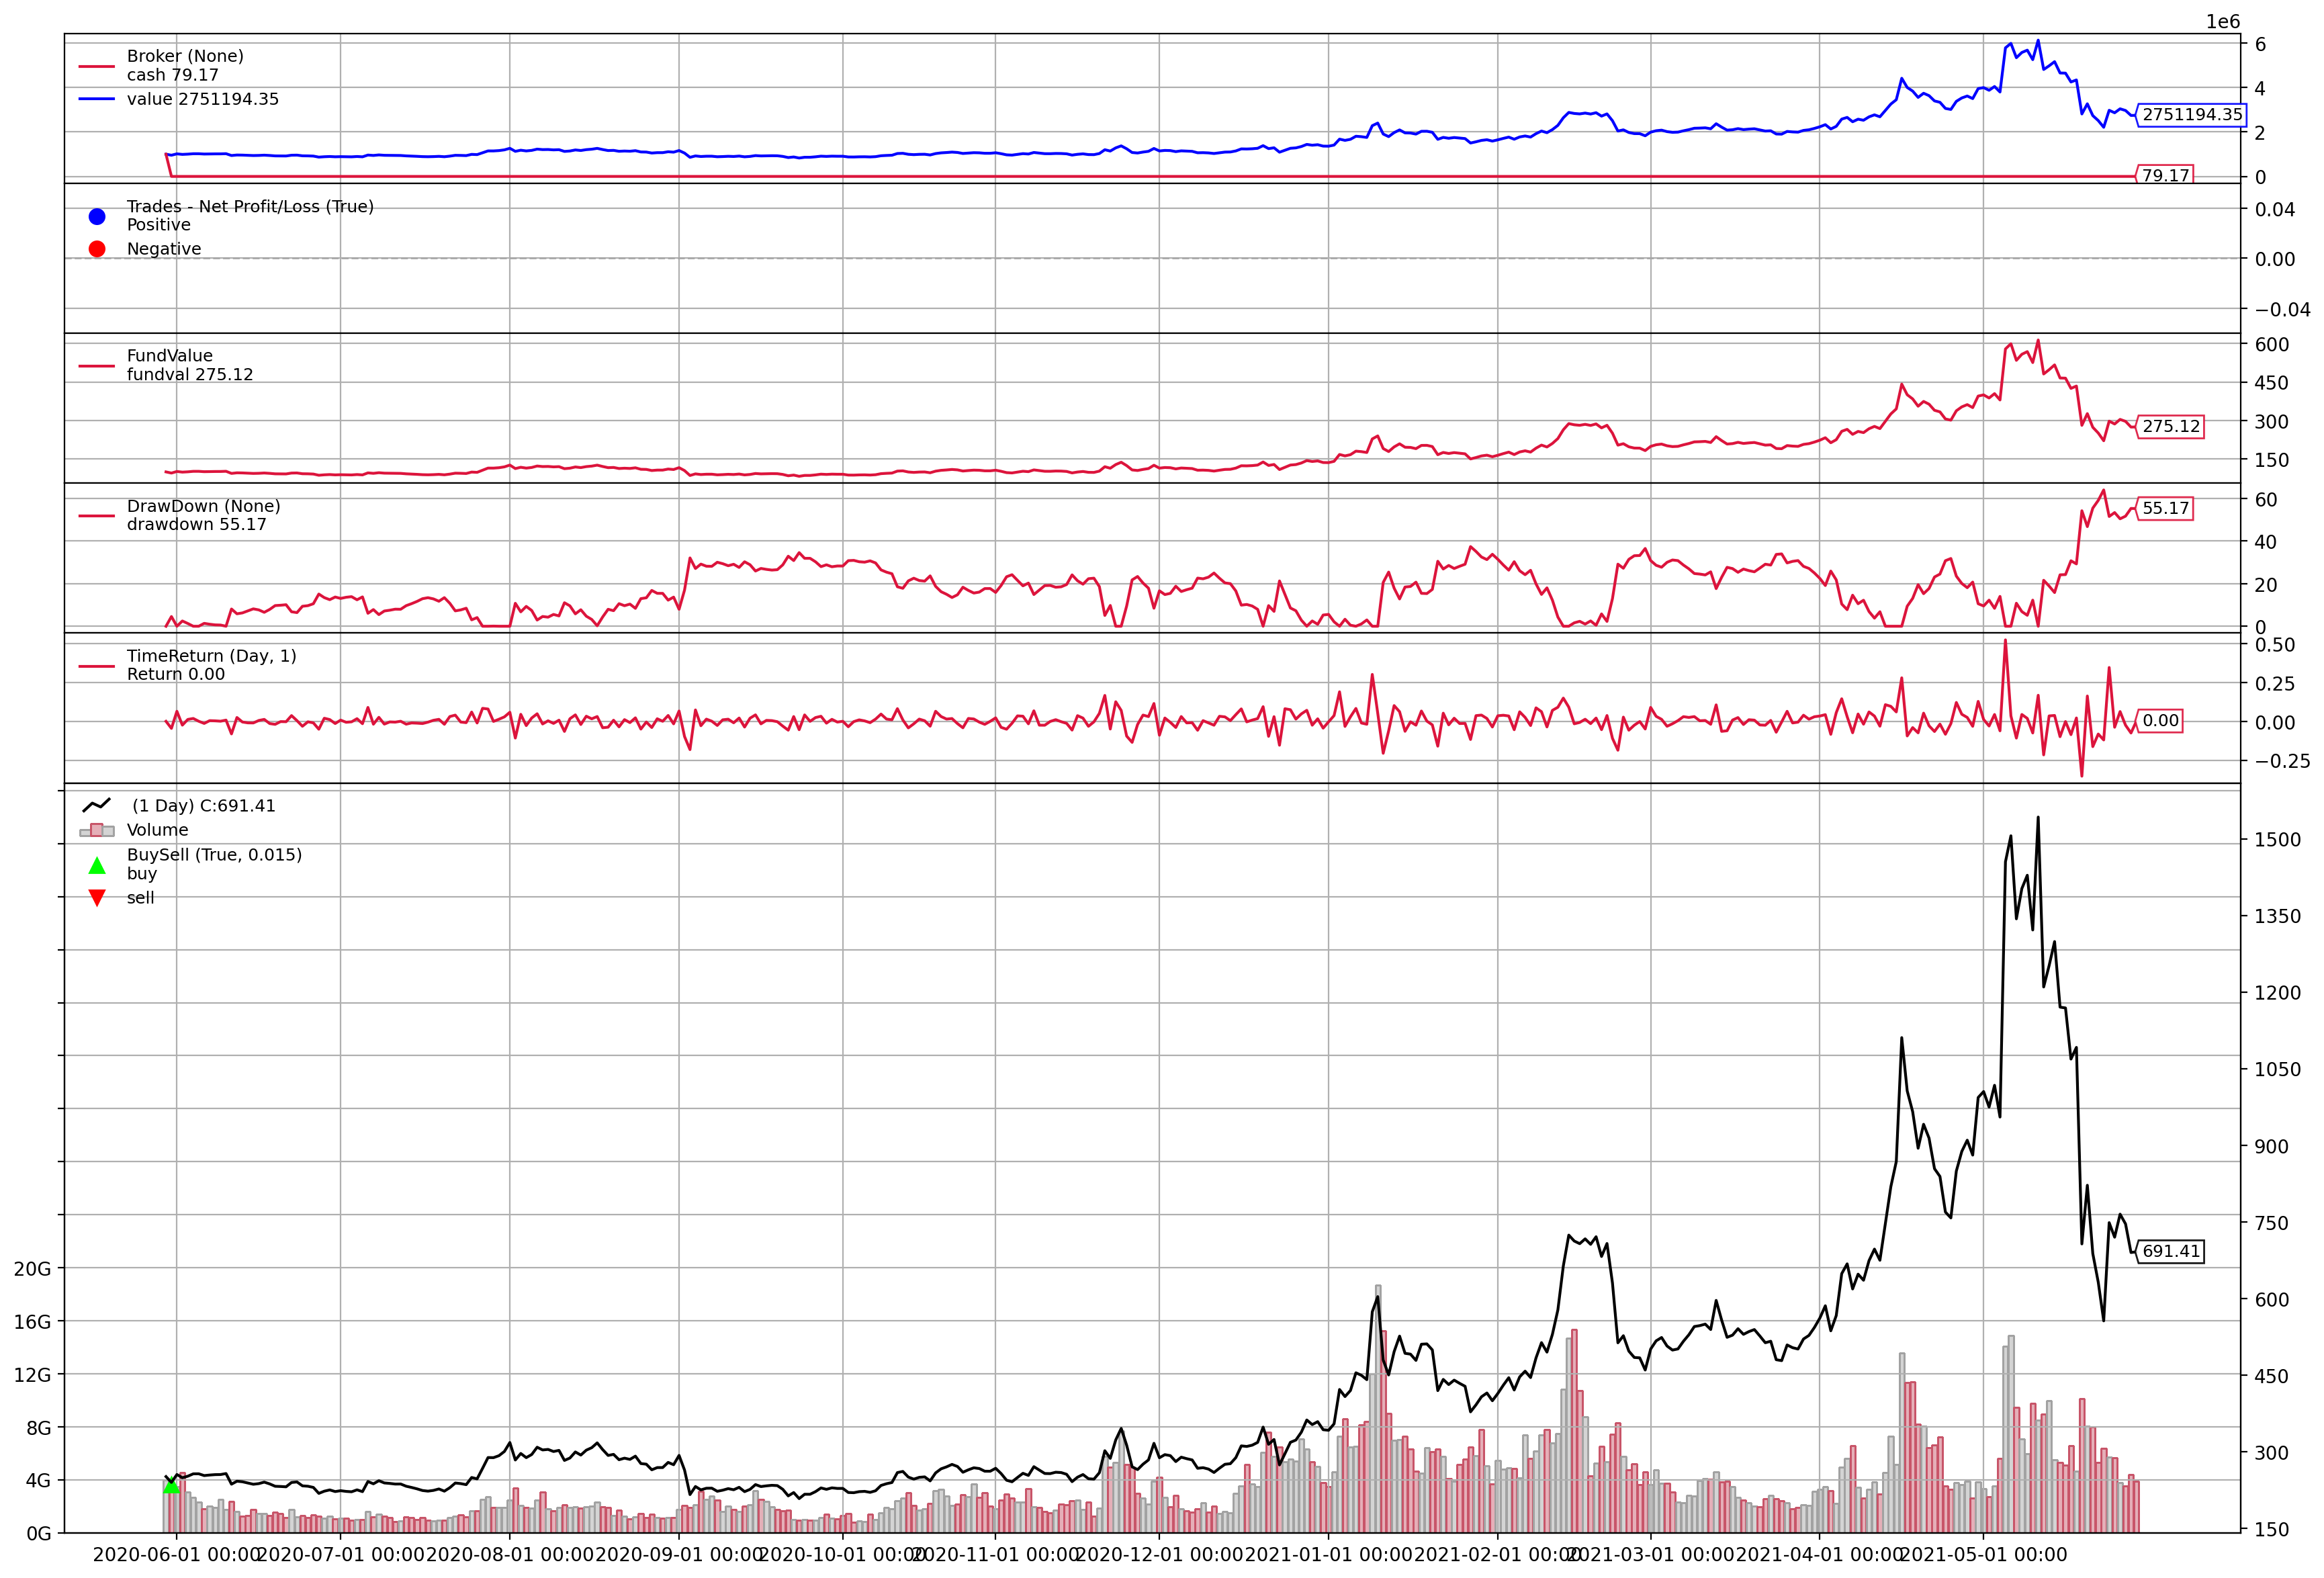

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2020, 5, 30), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-5-30',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - ADA

In [ ]:
ada_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/ADA-USD.csv', index_col=0, parse_dates=True)
ada_data.dropna(inplace=True)
train_len = int(0.7 * len(ada_data))
train_len

933

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=ada_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-06-20T00:00:00, 0060 - Order Target Percent: 0.0000
2020-06-21T00:00:00, BUY EXECUTED, Price: 0.08, Cost: 999999.94, Comm 0.00
Final Portfolio Value: 18978697.97


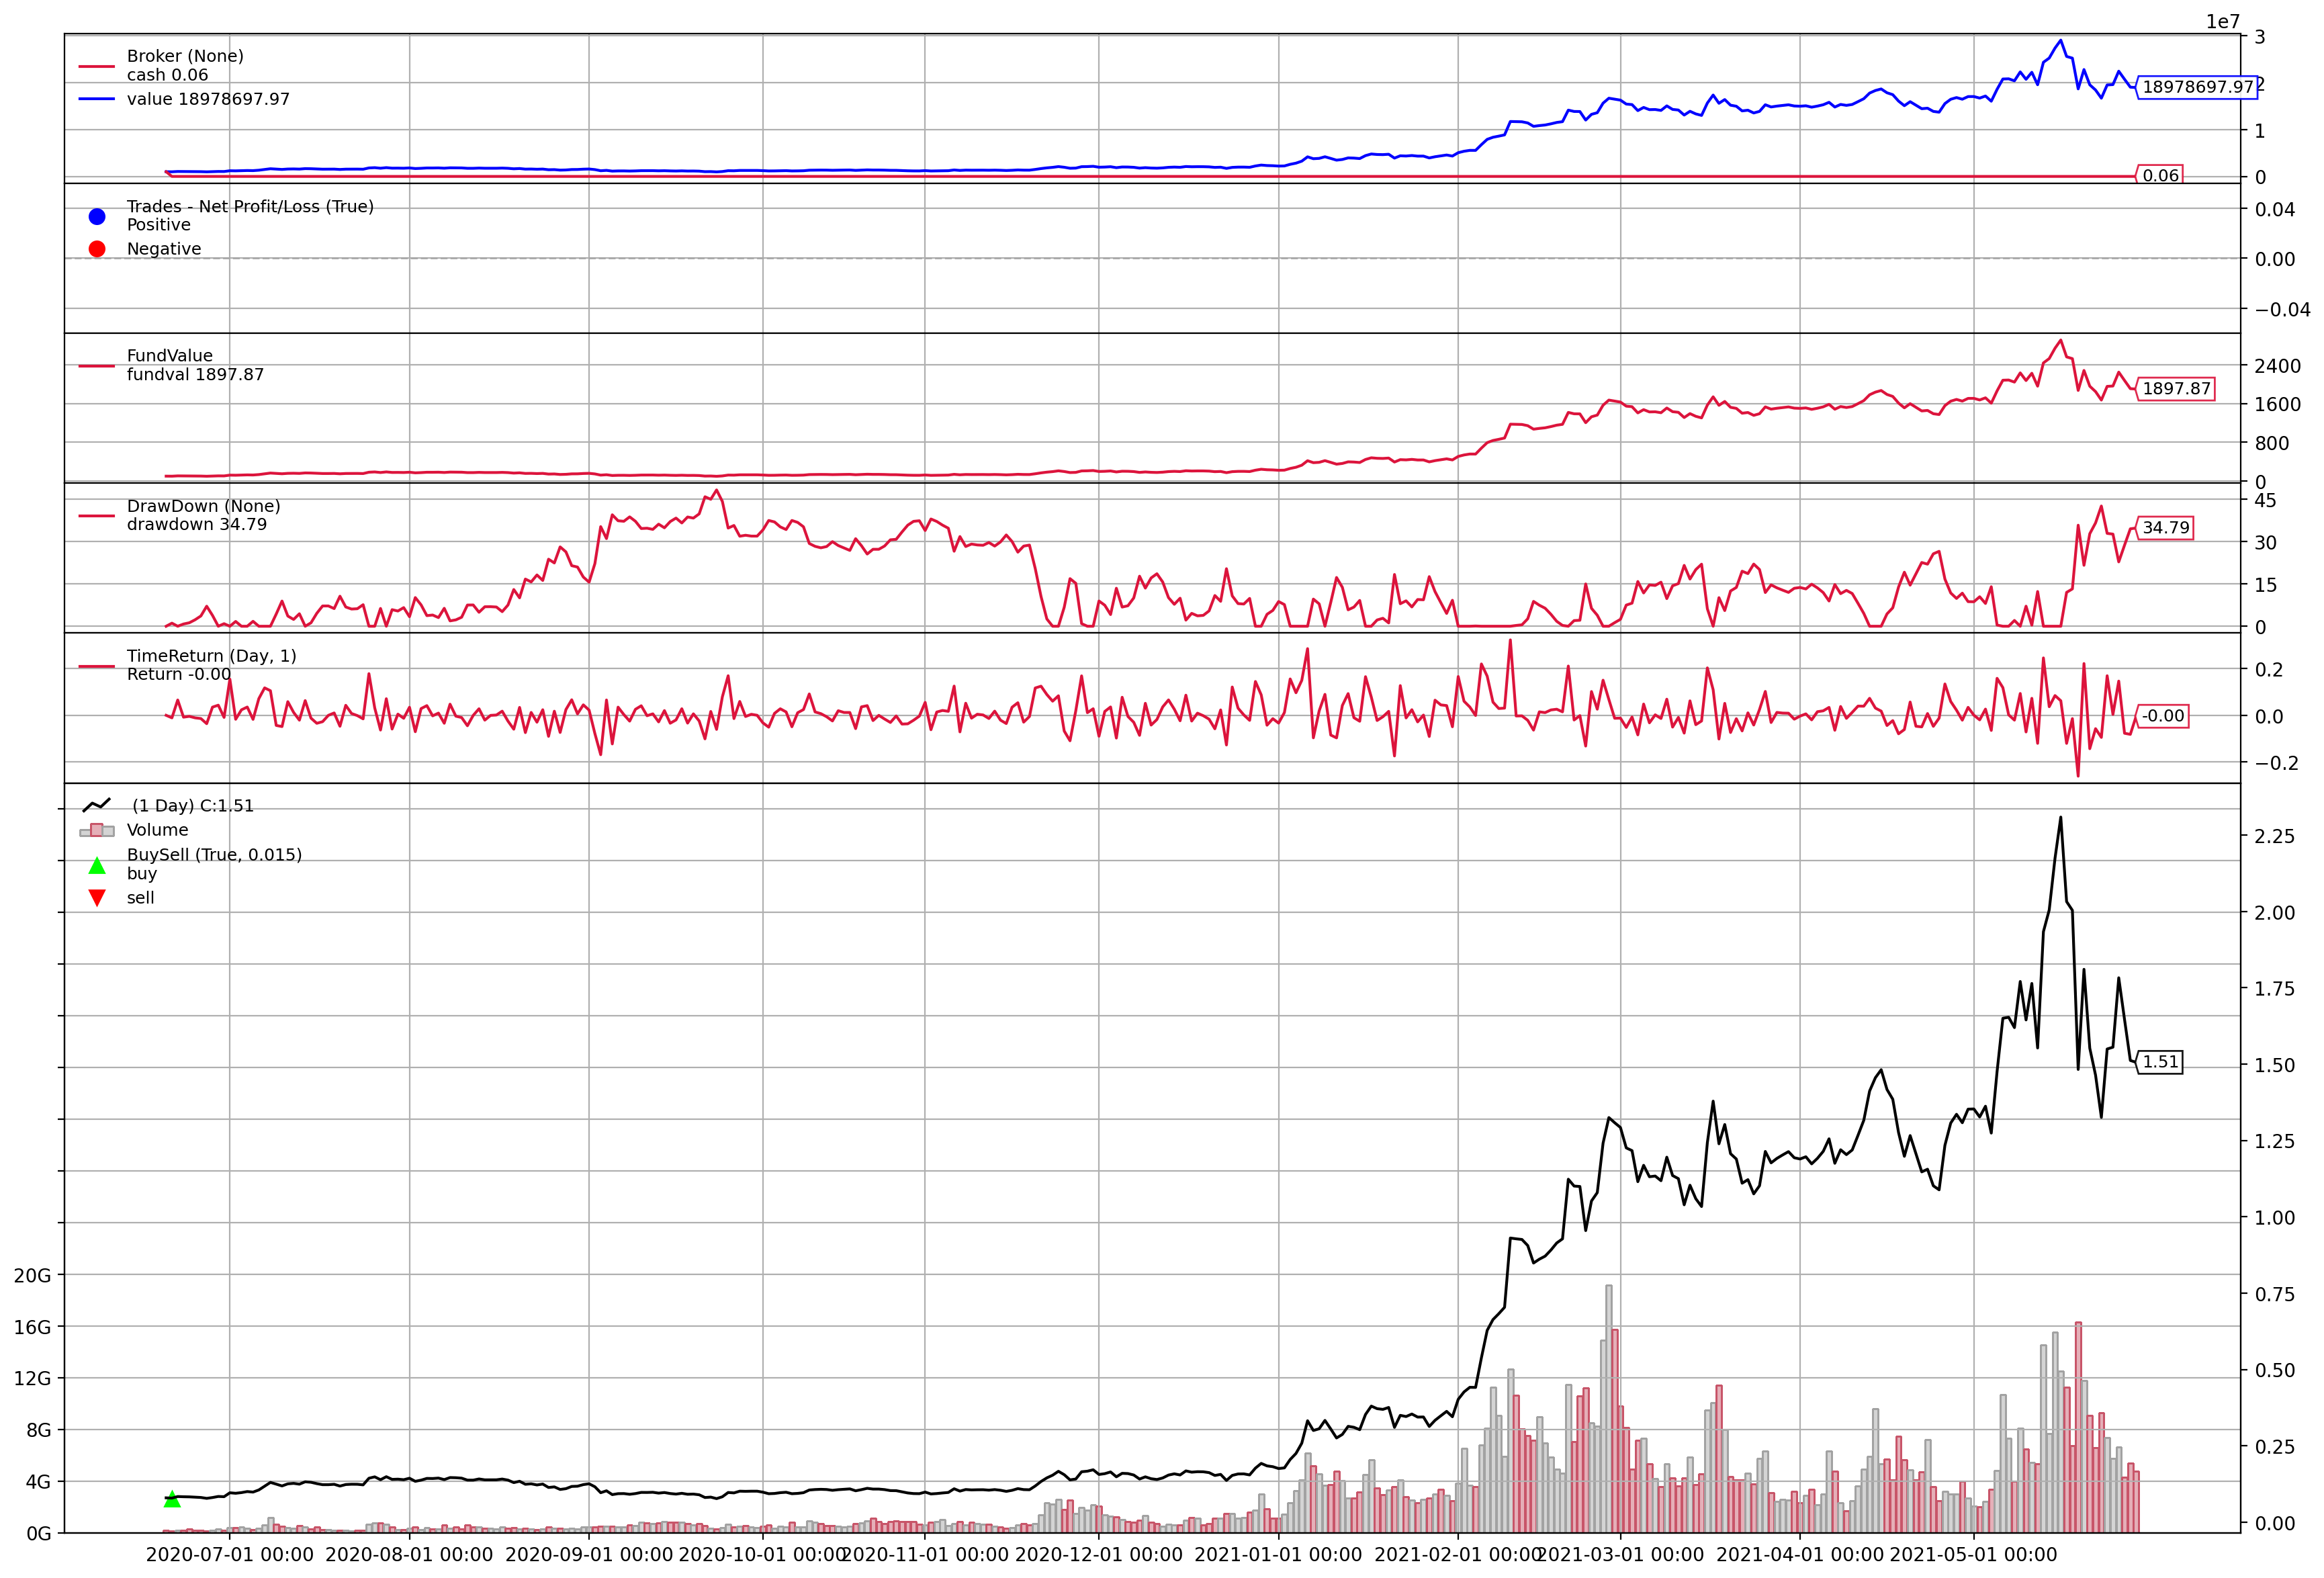

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2020, 6, 20), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-6-20',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### USD - BNB

In [ ]:
bnb_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BNB-USD.csv', index_col=0, parse_dates=True)
bnb_data.dropna(inplace=True)
train_len = int(0.7 * len(bnb_data))
train_len

980

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=bnb_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-05-30T00:00:00, 0060 - Order Target Percent: 0.0000
2020-05-31T00:00:00, BUY EXECUTED, Price: 17.74, Cost: 999983.55, Comm 0.00
Final Portfolio Value: 18990945.95


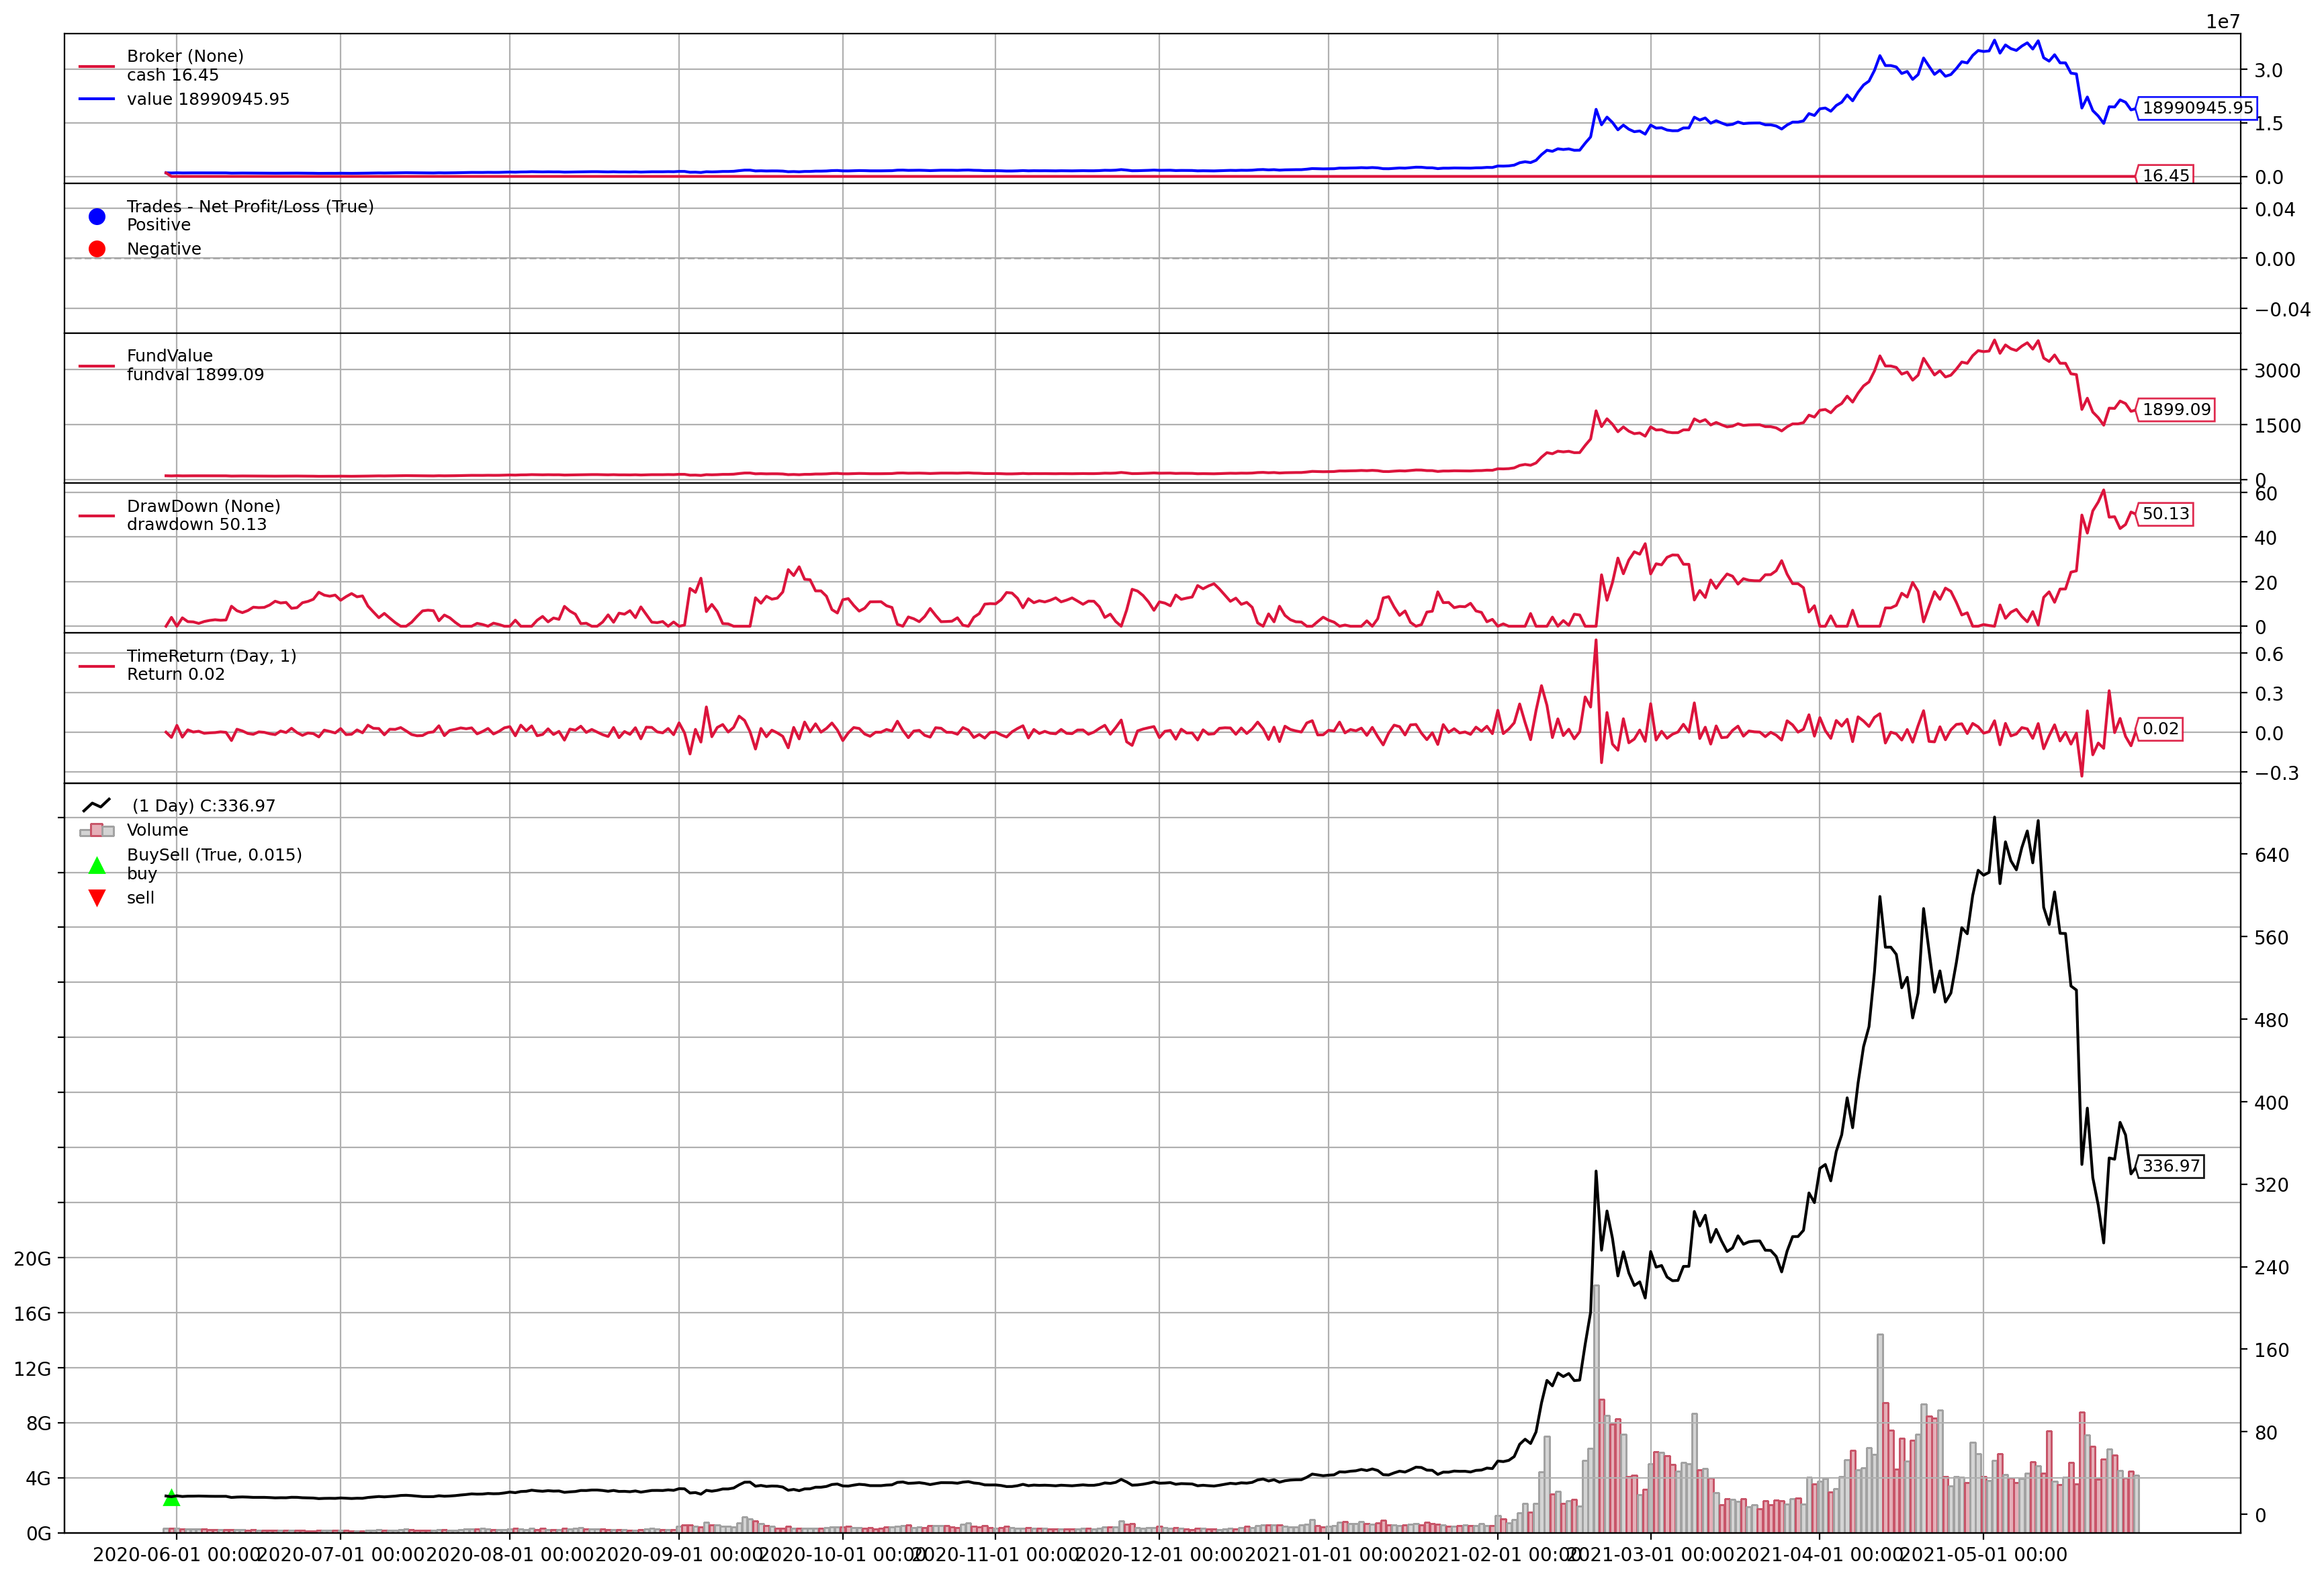

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2020, 5, 30), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-5-30',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## Stocks (S&P 500 big cap)

### AAPL

In [ ]:
aapl_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/AAPL.csv', index_col=0, parse_dates=True)
aapl_data.dropna(inplace=True)
train_len = int(0.9 * len(aapl_data))
train_len

2264

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=aapl_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-08-04T00:00:00, 0060 - Order Target Percent: 0.0000
2020-08-05T00:00:00, BUY EXECUTED, Price: 109.67, Cost: 999925.48, Comm 0.00
Final Portfolio Value: 1156692.80


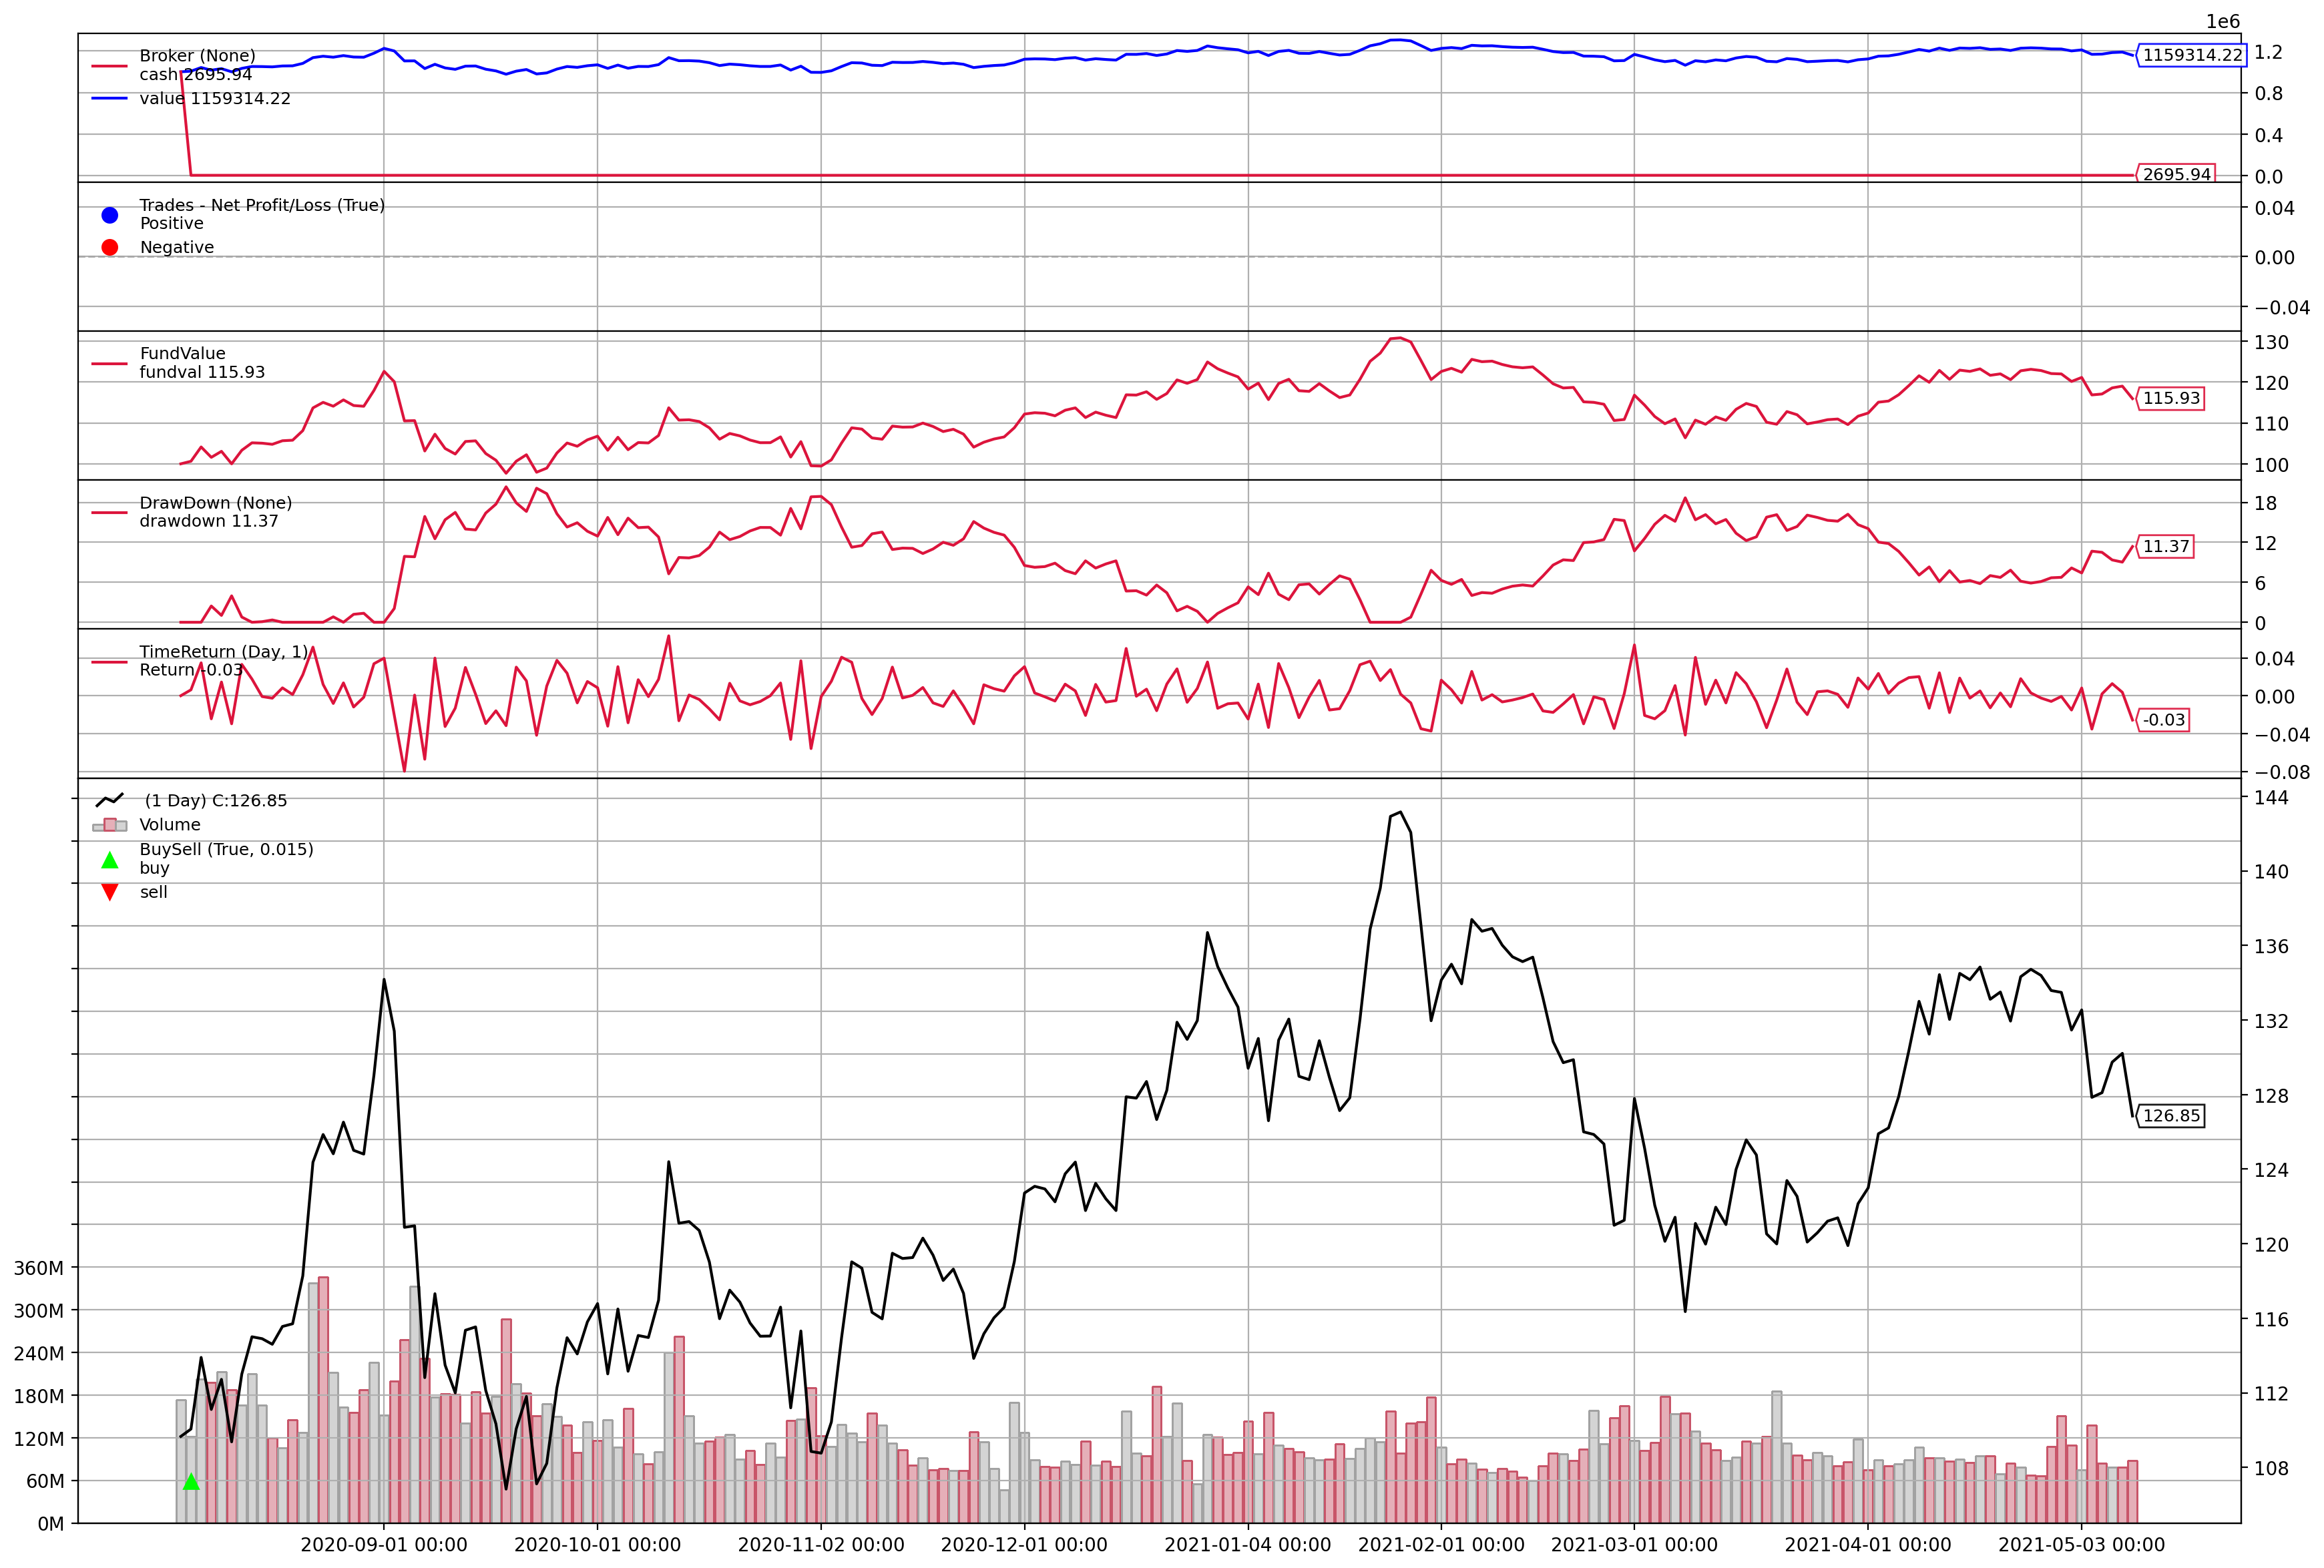

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2020, 8, 4), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-8-4',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### Yahoo

In [ ]:
yahoo_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/yhoo-1996-2015.txt', index_col=0, parse_dates=True)
yahoo_data.dropna(inplace=True)
train_len = int(0.9 * len(yahoo_data))
train_len

4468

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=yahoo_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2014-04-08T00:00:00, 0060 - Order Target Percent: 0.0000
2014-04-09T00:00:00, BUY EXECUTED, Price: 33.83, Cost: 999981.03, Comm 0.00
Final Portfolio Value: 983151.25


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2014-4-8',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### FB

In [ ]:
fb_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/FB.csv', index_col=0, parse_dates=True)
fb_data.dropna(inplace=True)
train_len = int(0.7 * len(fb_data))
train_len

1584

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = fb_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-11-28T00:00:00, 0060 - Order Target Percent: 0.0000
2018-11-29T00:00:00, BUY EXECUTED, Price: 136.76, Cost: 999989.08, Comm 0.00
Final Portfolio Value: 2266438.37


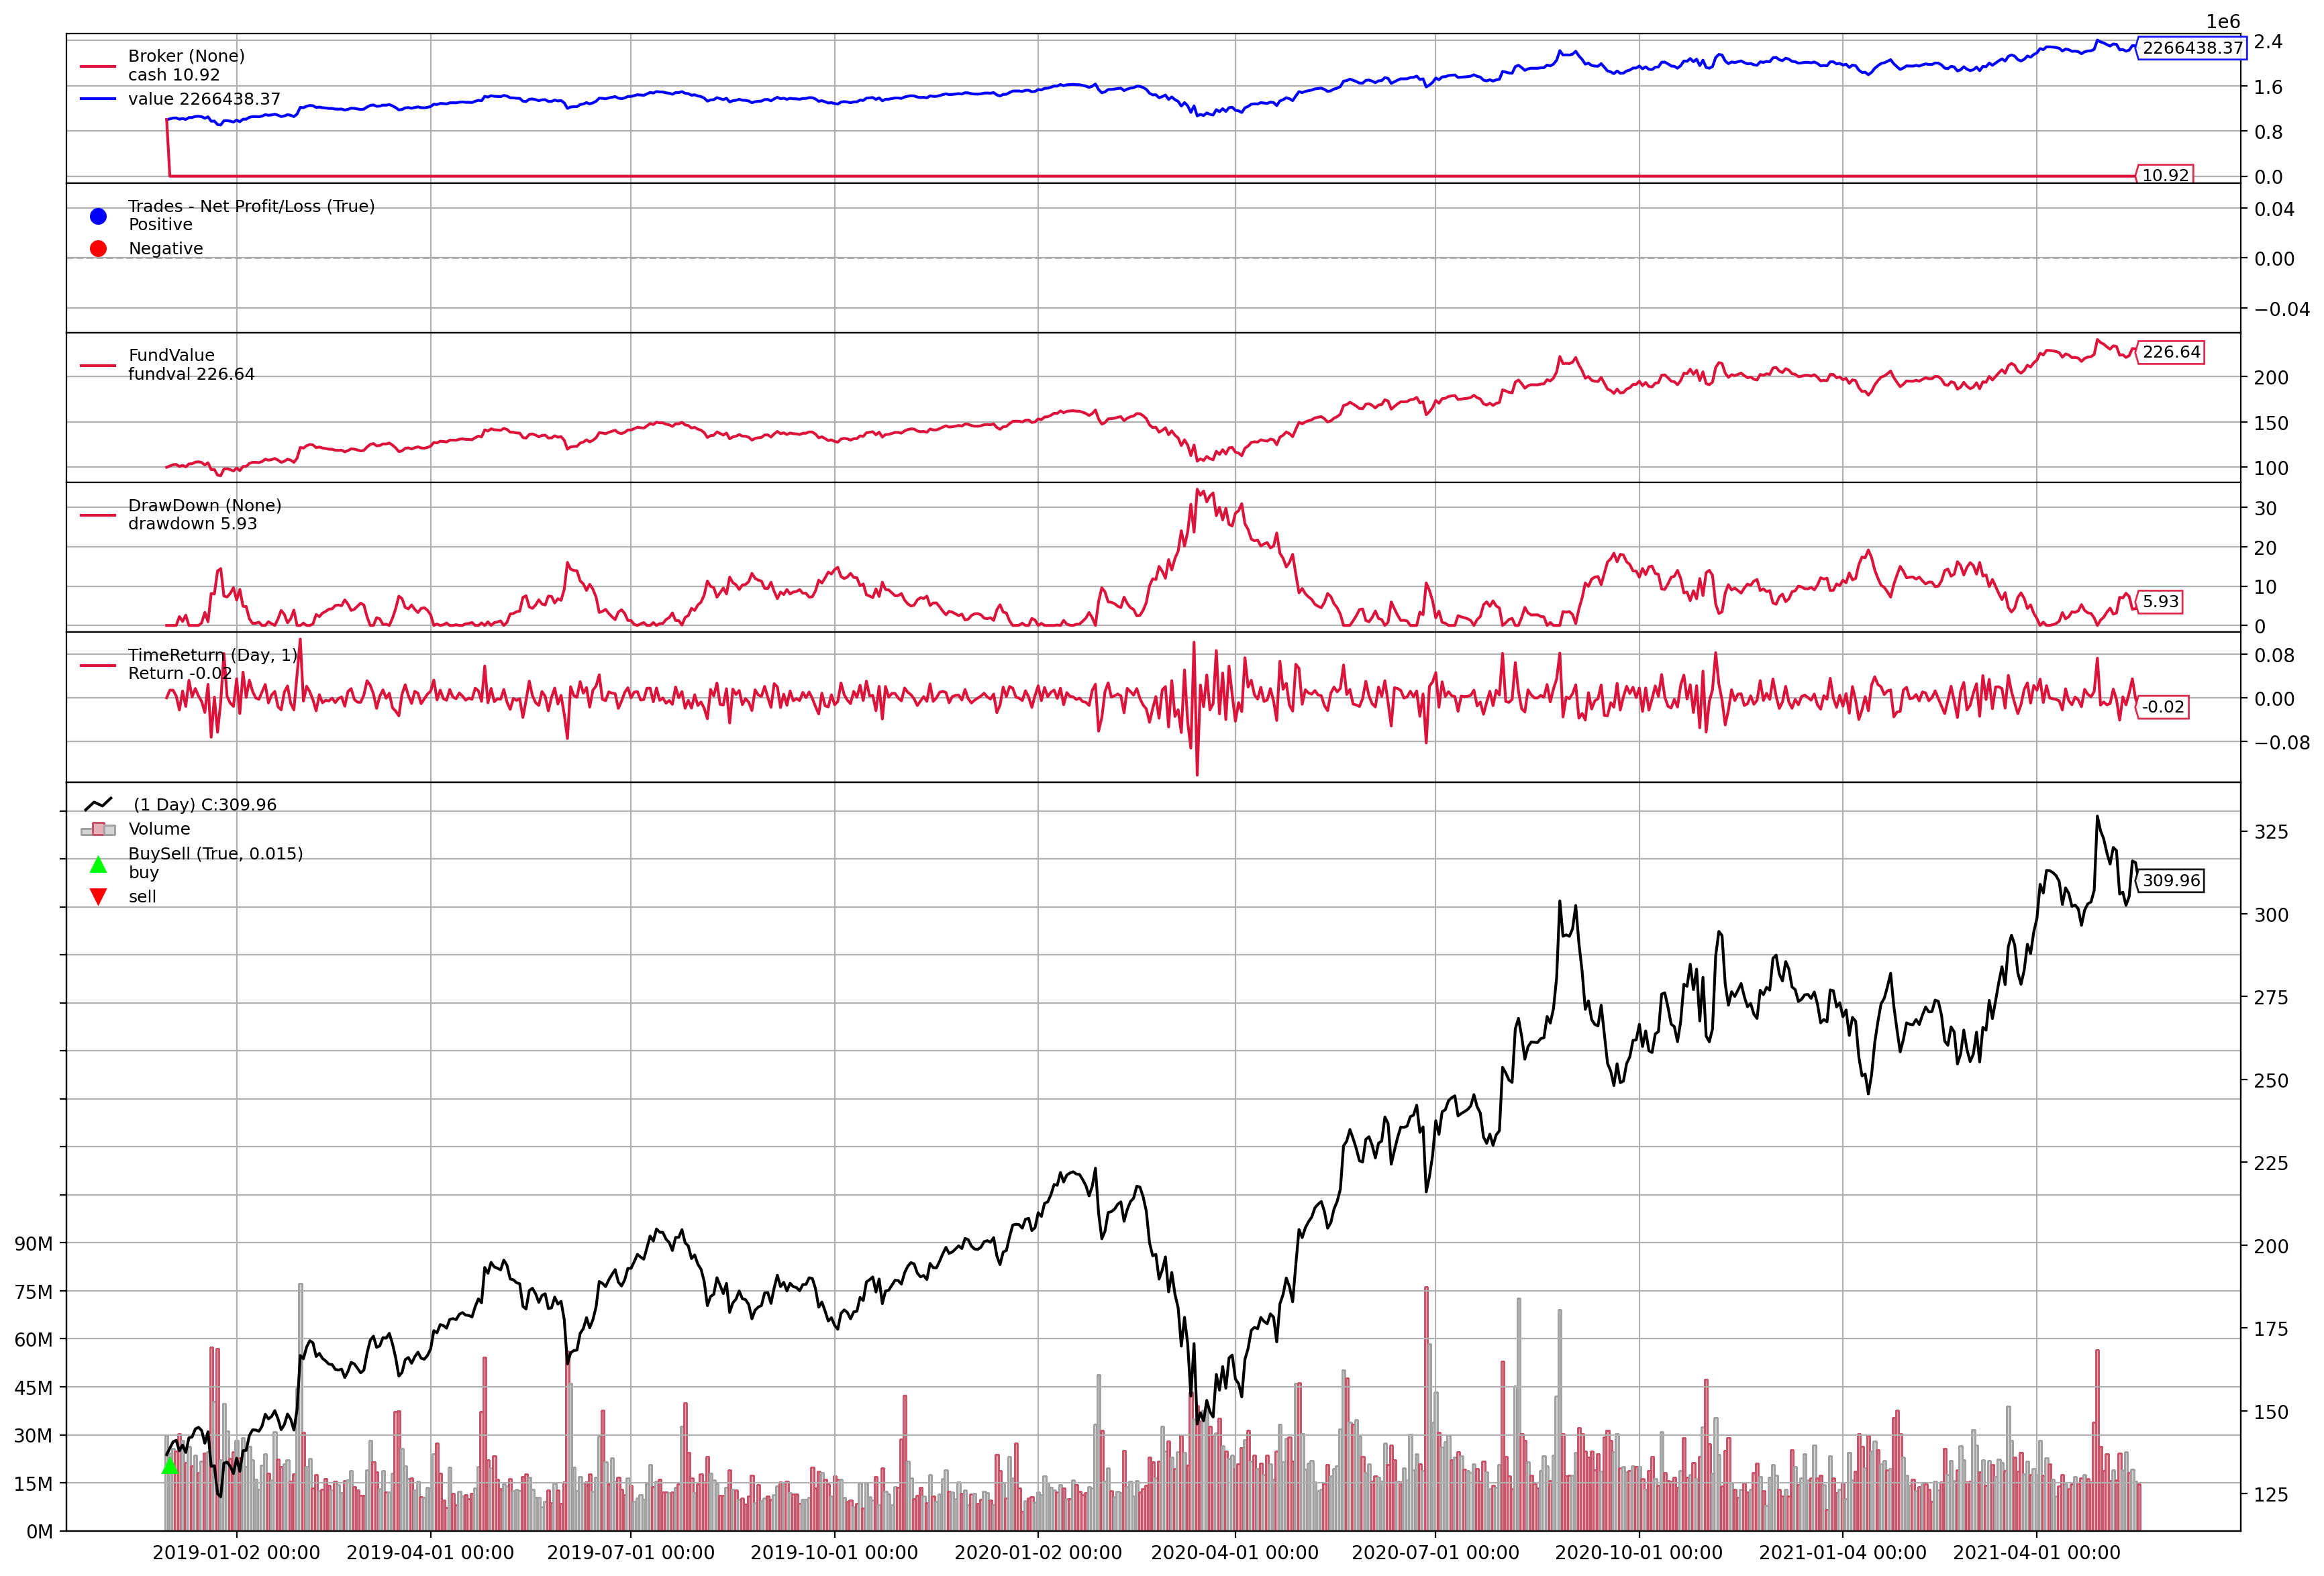

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2018, 11, 28), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-11-27',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### TSLA

In [ ]:
tsla_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/TSLA.csv', index_col=0, parse_dates=True)
tsla_data.dropna(inplace=True)
train_len = int(0.7 * len(tsla_data))
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = tsla_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-08-13T00:00:00, 0060 - Order Target Percent: 0.0000
2018-08-14T00:00:00, BUY EXECUTED, Price: 71.28, Cost: 999943.87, Comm 0.00
Final Portfolio Value: 8106416.42


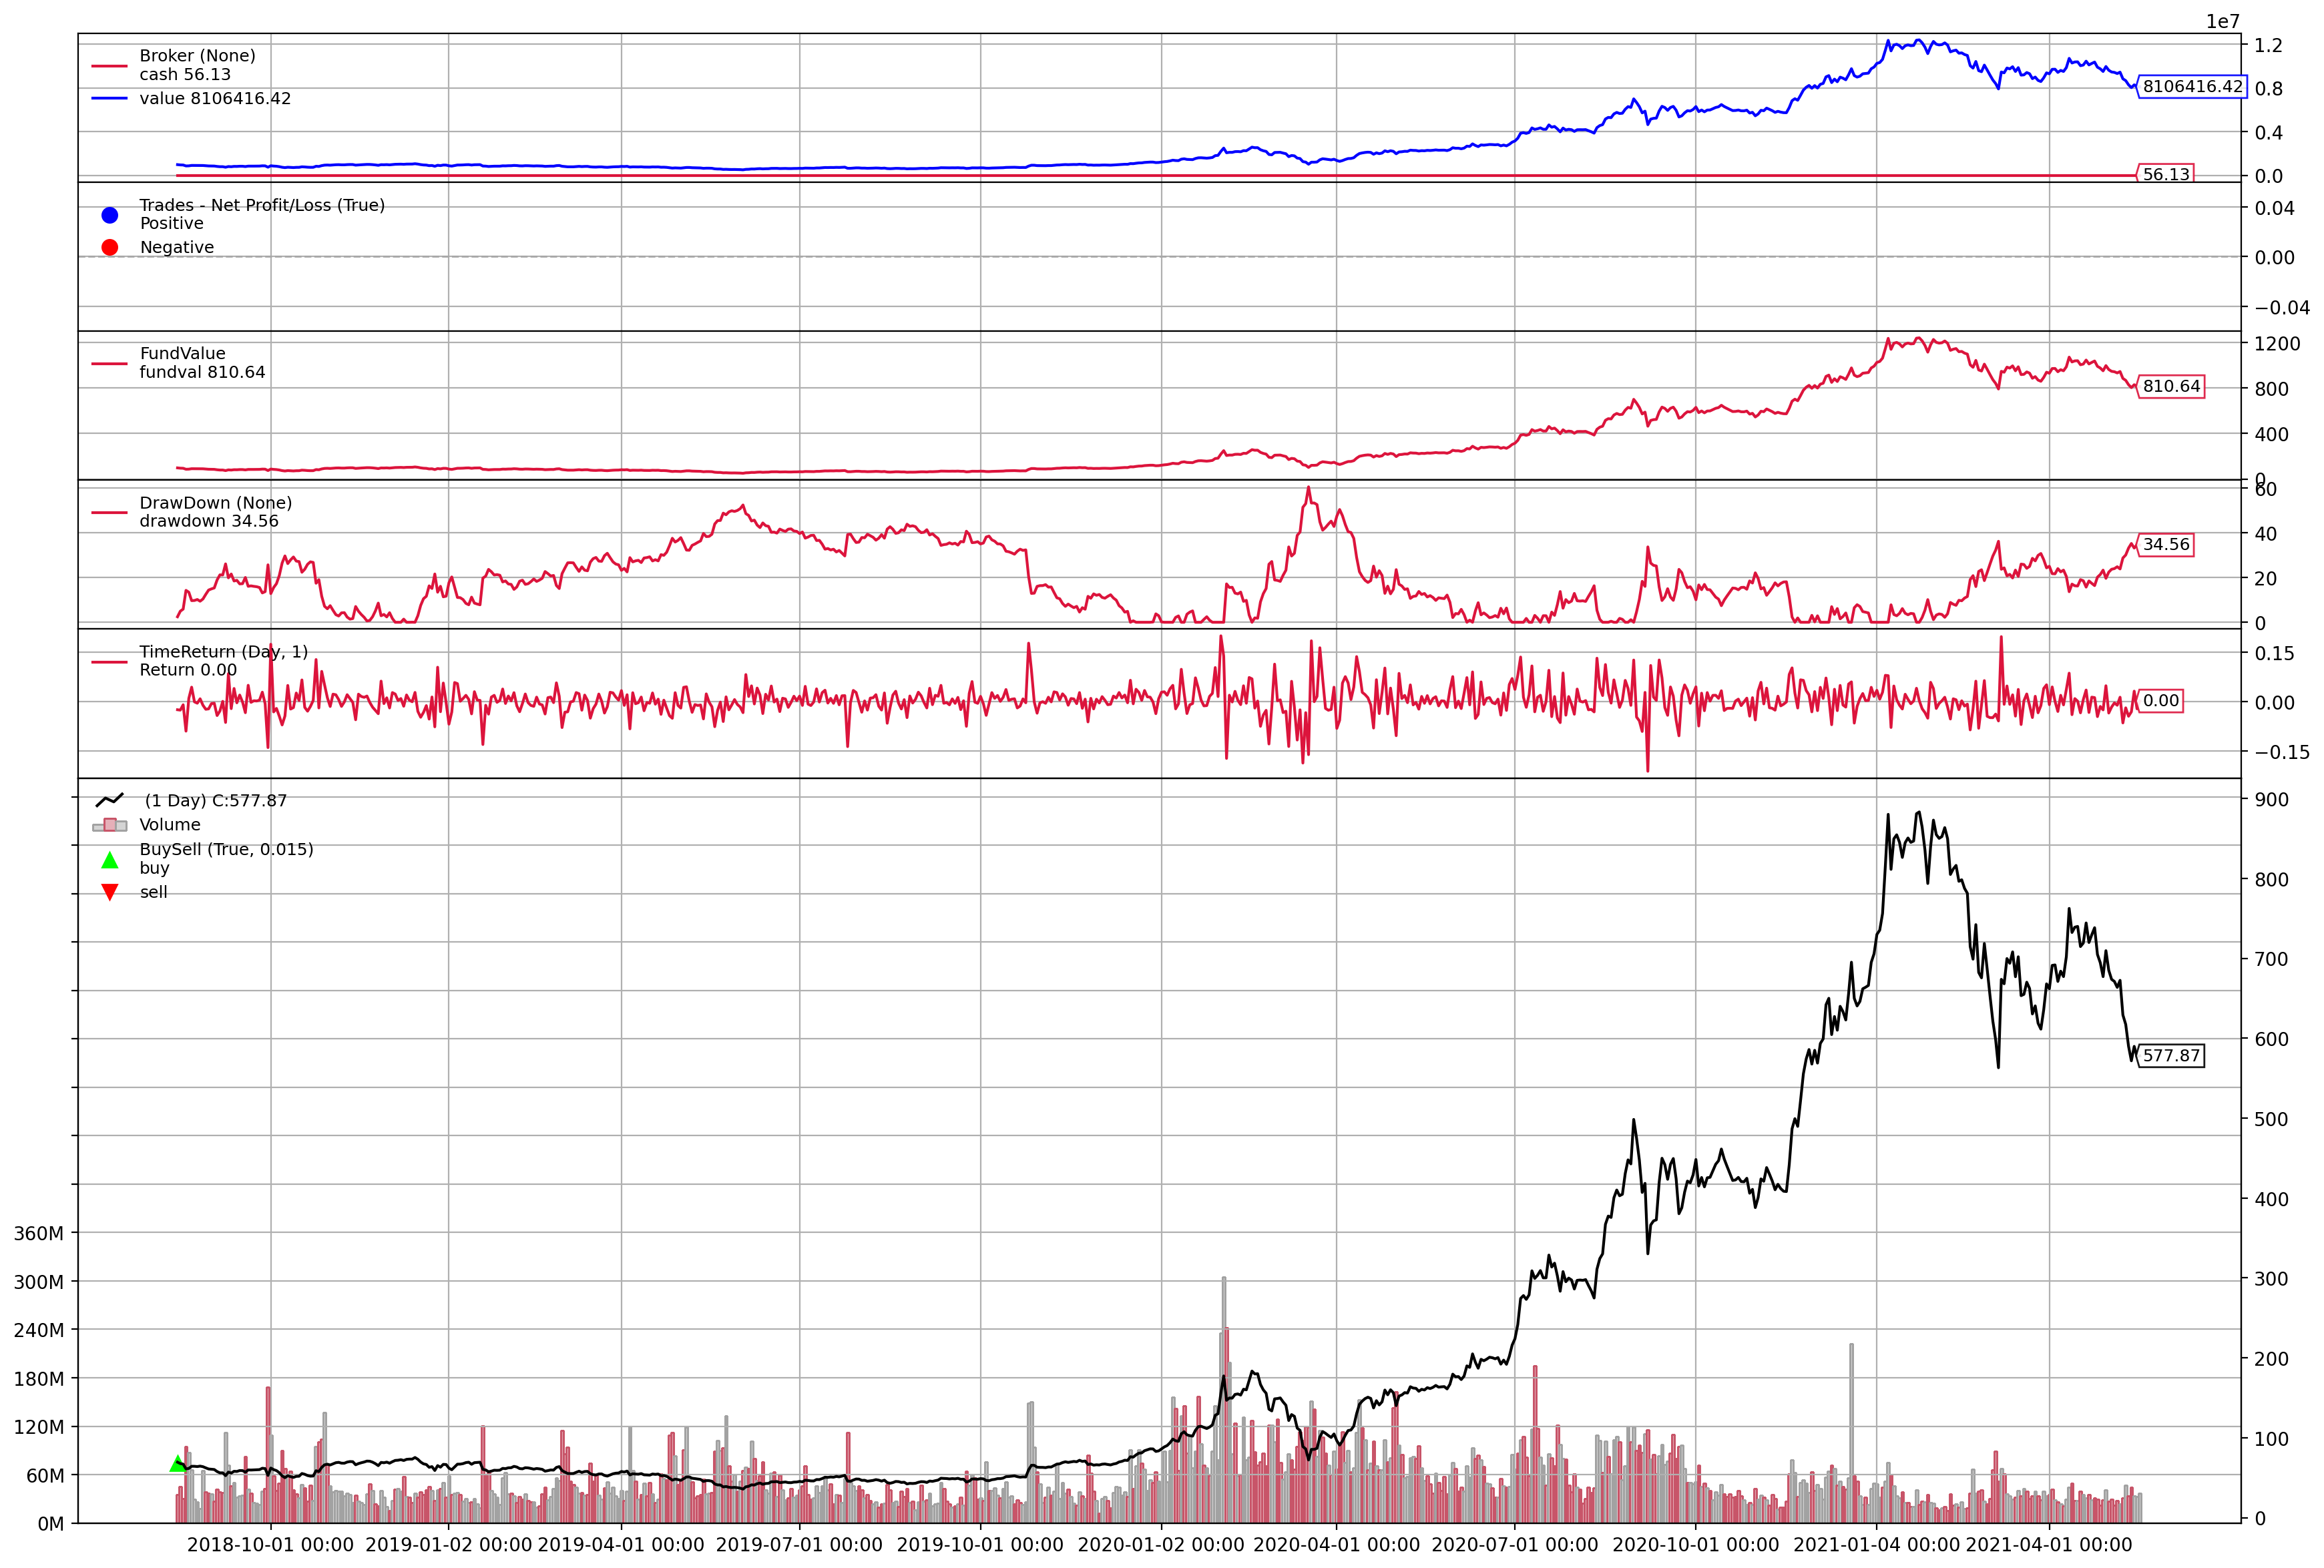

[[<Figure size 3600x2400 with 7 Axes>]]

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
cerebro.plot(start=dt.date(2018, 8, 14), iplot=False)

In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-8-14',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### GOOGL

In [ ]:
googl_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/GOOGL.csv', index_col=0, parse_dates=True)
googl_data.dropna(inplace=True)
train_len = int(0.7 * len(googl_data))
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = googl_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-08-13T00:00:00, 0060 - Order Target Percent: 0.0000
2018-08-14T00:00:00, BUY EXECUTED, Price: 1248.64, Cost: 998912.01, Comm 0.00
Final Portfolio Value: 1811063.96


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-8-14',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### BRK-B

In [ ]:
brkb_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/BRK-B.csv', index_col=0, parse_dates=True)
brkb_data.dropna(inplace=True)
train_len = int(0.7 * len(brkb_data))
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = brkb_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-08-13T00:00:00, 0060 - Order Target Percent: 0.0000
2018-08-14T00:00:00, BUY EXECUTED, Price: 205.17, Cost: 999998.57, Comm 0.00
Final Portfolio Value: 1401715.07


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-8-14',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### JPM

In [ ]:
jpm_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/JPM.csv', index_col=0, parse_dates=True)
jpm_data.dropna(inplace=True)
train_len = int(0.7 * len(jpm_data))
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = jpm_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-08-13T00:00:00, 0060 - Order Target Percent: 0.0000
2018-08-14T00:00:00, BUY EXECUTED, Price: 113.89, Cost: 999954.19, Comm 0.00
Final Portfolio Value: 1425478.86


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-8-14',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### JNJ

In [ ]:
jnj_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/JNJ.csv', index_col=0, parse_dates=True)
jnj_data.dropna(inplace=True)
train_len = int(0.7 * len(jnj_data))
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = jnj_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-08-13T00:00:00, 0060 - Order Target Percent: 0.0000
2018-08-14T00:00:00, BUY EXECUTED, Price: 130.22, Cost: 999959.39, Comm 0.00
Final Portfolio Value: 1308926.14


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-8-14',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### SPY

In [ ]:
spy_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/SPY.csv', index_col=0, parse_dates=True)
spy_data.dropna(inplace=True)
train_len = int(0.7 * len(spy_data))
train_len

1761

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = spy_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-08-13T00:00:00, 0060 - Order Target Percent: 0.0000
2018-08-14T00:00:00, BUY EXECUTED, Price: 282.10, Cost: 999762.42, Comm 0.00
Final Portfolio Value: 1460152.95


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-8-14',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


##Stocks (HSI top )

### 0700 (Tencent)

In [ ]:
tencent_data = pd.read_csv(r'/content/drive/My Drive/CFE/0700.HK.csv', index_col=0, parse_dates=True)
tencent_data.dropna(inplace=True)
train_len = int(0.7 * len(tencent_data))
train_len

864

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = tencent_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-02-12T00:00:00, 0060 - Order Target Percent: 0.0000
2020-02-13T00:00:00, BUY EXECUTED, Price: 411.00, Cost: 999963.00, Comm 0.00
Final Portfolio Value: 1461053.50


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 1398 (ICBC)

In [ ]:
icbc_data = pd.read_csv(r'/content/drive/My Drive/CFE/1398.HK.csv', index_col=0, parse_dates=True)
icbc_data.dropna(inplace=True)
train_len = int(0.7 * len(icbc_data))
train_len

864

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = icbc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-02-12T00:00:00, 0060 - Order Target Percent: 0.0000
2020-02-13T00:00:00, BUY EXECUTED, Price: 5.56, Cost: 999999.36, Comm 0.00
Final Portfolio Value: 888489.28


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 4333 (CISCO-T)

In [ ]:
cisco_data = pd.read_csv(r'/content/drive/My Drive/CFE/4333.HK.csv', index_col=0, parse_dates=True)
cisco_data.dropna(inplace=True)
train_len = int(0.7 * len(cisco_data))
train_len

864

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = cisco_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-02-12T00:00:00, 0060 - Order Target Percent: 0.0000
2020-02-13T00:00:00, BUY EXECUTED, Price: 400.00, Cost: 1000000.00, Comm 0.00
Final Portfolio Value: 573499.98


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 3968 (CM Bank)

In [ ]:
cm_data = pd.read_csv(r'/content/drive/My Drive/CFE/3968.HK.csv', index_col=0, parse_dates=True)
cm_data.dropna(inplace=True)
train_len = int(0.7 * len(cm_data))
train_len

864

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = cm_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-02-12T00:00:00, 0060 - Order Target Percent: 0.0000
2020-02-13T00:00:00, BUY EXECUTED, Price: 38.85, Cost: 999998.95, Comm 0.00
Final Portfolio Value: 1746460.00


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 939 (CCB)

In [ ]:
ccb_data = pd.read_csv(r'/content/drive/My Drive/CFE/0939.HK.csv', index_col=0, parse_dates=True)
ccb_data.dropna(inplace=True)
train_len = int(0.7 * len(ccb_data))
train_len

864

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ccb_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-02-12T00:00:00, 0060 - Order Target Percent: 0.0000
2020-02-13T00:00:00, BUY EXECUTED, Price: 6.50, Cost: 999999.00, Comm 0.00
Final Portfolio Value: 958461.58


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 2318 (Ping An)

In [ ]:
pingan_data = pd.read_csv(r'/content/drive/My Drive/CFE/2318.HK.csv', index_col=0, parse_dates=True)
pingan_data.dropna(inplace=True)
train_len = int(0.7 * len(pingan_data))
train_len

864

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = pingan_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-02-12T00:00:00, 0060 - Order Target Percent: 0.0000
2020-02-13T00:00:00, BUY EXECUTED, Price: 91.60, Cost: 999997.18, Comm 0.00
Final Portfolio Value: 890830.00


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 1288 (ABC)

In [ ]:
abc_data = pd.read_csv(r'/content/drive/My Drive/CFE/1288.HK.csv', index_col=0, parse_dates=True)
abc_data.dropna(inplace=True)
train_len = int(0.7 * len(abc_data))
train_len

864

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = abc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-02-12T00:00:00, 0060 - Order Target Percent: 0.0000
2020-02-13T00:00:00, BUY EXECUTED, Price: 3.12, Cost: 999997.44, Comm 0.00
Final Portfolio Value: 980769.28


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 1299 (AIA)

In [ ]:
aia_data = pd.read_csv(r'/content/drive/My Drive/CFE/1299.HK.csv', index_col=0, parse_dates=True)
aia_data.dropna(inplace=True)
train_len = int(0.7 * len(aia_data))
train_len

864

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = aia_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-02-12T00:00:00, 0060 - Order Target Percent: 0.0000
2020-02-13T00:00:00, BUY EXECUTED, Price: 81.35, Cost: 999954.18, Comm 0.00
Final Portfolio Value: 1264892.65


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


###0857 (Petrochina)

In [ ]:
petrochina_data = pd.read_csv(r'/content/drive/My Drive/CFE/0857.HK.csv', index_col=0, parse_dates=True)
petrochina_data.dropna(inplace=True)
train_len = int(0.7 * len(petrochina_data))
train_len

864

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = petrochina_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-02-12T00:00:00, 0060 - Order Target Percent: 0.0000
2020-02-13T00:00:00, BUY EXECUTED, Price: 3.50, Cost: 999999.00, Comm 0.00
Final Portfolio Value: 897142.96


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 3988 (Bank of China)

In [ ]:
boc_data = pd.read_csv(r'/content/drive/My Drive/CFE/3988.HK.csv', index_col=0, parse_dates=True)
boc_data.dropna(inplace=True)
train_len = int(0.7 * len(boc_data))
train_len

864

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = boc_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2020-02-12T00:00:00, 0060 - Order Target Percent: 0.0000
2020-02-13T00:00:00, BUY EXECUTED, Price: 3.19, Cost: 999998.01, Comm 0.00
Final Portfolio Value: 978056.47


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2020-02-12',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


## SSE

### 601628 (China Life Insurance)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601628.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
train_len = int(0.7 * len(ss_raw_data))
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-09-21T00:00:00, 0060 - Order Target Percent: 0.0000
2018-09-25T00:00:00, BUY EXECUTED, Price: 22.06, Cost: 999979.75, Comm 0.00
Final Portfolio Value: 1450126.95


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-09-05',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 601857 (Petrochina)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601857.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
train_len = int(0.7 * len(ss_raw_data))
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-09-21T00:00:00, 0060 - Order Target Percent: 0.0000
2018-09-25T00:00:00, BUY EXECUTED, Price: 8.81, Cost: 999996.67, Comm 0.00
Final Portfolio Value: 593644.94


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-09-05',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 601318 (Ping An Insurance)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601318.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
train_len = int(0.7 * len(ss_raw_data))
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-09-21T00:00:00, 0060 - Order Target Percent: 0.0000
2018-09-25T00:00:00, BUY EXECUTED, Price: 67.49, Cost: 999999.30, Comm 0.00
Final Portfolio Value: 923099.78


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-09-05',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 601939 (China Construction Bank)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601939.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
train_len = int(0.7 * len(ss_raw_data))
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-09-21T00:00:00, 0060 - Order Target Percent: 0.0000
2018-09-25T00:00:00, BUY EXECUTED, Price: 7.21, Cost: 999998.16, Comm 0.00
Final Portfolio Value: 926491.12


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-09-05',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 600036 (China Merchants Bank)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/600036.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
train_len = int(0.7 * len(ss_raw_data))
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-09-21T00:00:00, 0060 - Order Target Percent: 0.0000
2018-09-25T00:00:00, BUY EXECUTED, Price: 30.30, Cost: 999990.87, Comm 0.00
Final Portfolio Value: 1750818.25


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-09-05',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 601398 (Industrial and Commercial Bank of China)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/601398.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
train_len = int(0.7 * len(ss_raw_data))
train_len

1700

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-09-21T00:00:00, 0060 - Order Target Percent: 0.0000
2018-09-25T00:00:00, BUY EXECUTED, Price: 5.75, Cost: 999999.75, Comm 0.00
Final Portfolio Value: 913043.50


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-09-05',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


### 600519 (Kweichow Moutai)

In [ ]:
ss_raw_data = pd.read_csv(r'/content/drive/My Drive/lstm_stock_predictions/600519.SS.csv', index_col=0, parse_dates=True)
ss_raw_data.dropna(inplace=True)
train_len = int(0.7 * len(ss_raw_data))
train_len

1701

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname = ss_raw_data[train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)


# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2018-06-26T00:00:00, 0060 - Order Target Percent: 0.0000
2018-06-27T00:00:00, BUY EXECUTED, Price: 754.80, Cost: 999355.18, Comm 0.00
Final Portfolio Value: 2722855.08


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      live_start_date='2018-03-30',  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Skip


# Phase 2

##2 week data


### Parse the raw_data


In [ ]:
raw_data = pd.read_csv('/content/drive/My Drive/lstm_stock_predictions/crypto_2_weeks.csv', index_col=0, parse_dates=True)
crypto_data = {}
for name in raw_data.index.unique() :
  print(name)
  crypto_data[name] = pd.DataFrame()
  crypto_data[name]['Time'] = pd.to_datetime(raw_data.loc[name]['TIME'], format='%d-%m-%y %H:%M:%S')
  crypto_data[name]['Close'] = (raw_data.loc[name]['ASK'] + raw_data.loc[name]['BID'])/2
  crypto_data[name] = crypto_data[name].set_index('Time')
  crypto_data[name] = crypto_data[name].sort_index()


YFI/USD
UNI/USD
LINK/USD
ADA/USD
DOT/USD
DOG/USD
UST/USD
LTC/USD
ETH/USD
BTC/USD


###YFI-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['YFI/USD']))
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['YFI/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:37:51, 0060 - Order Target Percent: 0.0000
2021-06-11T02:38:01, BUY EXECUTED, Price: 37312.50, Cost: 970125.00, Comm 0.00
Final Portfolio Value: 959700.00


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


### UNI-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['UNI/USD']))
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UNI/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:37:51, 0060 - Order Target Percent: 0.0000
2021-06-11T02:38:01, BUY EXECUTED, Price: 22.81, Cost: 999986.83, Comm 0.00
Final Portfolio Value: 911254.02


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###LINK-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['LINK/USD']))
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LINK/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:37:51, 0060 - Order Target Percent: 0.0000
2021-06-11T02:38:01, BUY EXECUTED, Price: 22.67, Cost: 999992.67, Comm 0.00
Final Portfolio Value: 924734.82


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###ADA-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['ADA/USD']))
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ADA/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:37:51, 0060 - Order Target Percent: 0.0000
2021-06-11T02:38:01, BUY EXECUTED, Price: 1.51, Cost: 999999.32, Comm 0.00
Final Portfolio Value: 957048.74


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###DOT-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['DOT/USD']))
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOT/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:37:51, 0060 - Order Target Percent: 0.0000
2021-06-11T02:38:01, BUY EXECUTED, Price: 22.58, Cost: 999999.15, Comm 0.00
Final Portfolio Value: 906007.21


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###DOG-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['DOG/USD']))
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOG/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:37:51, 0060 - Order Target Percent: 0.0000
2021-06-11T02:38:01, BUY EXECUTED, Price: 321110.00, Cost: 963330.00, Comm 0.00
Final Portfolio Value: 967255.00


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###UST-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['UST/USD']))
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UST/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:37:50, 0060 - Order Target Percent: 0.0000
2021-06-11T02:38:00, BUY EXECUTED, Price: 1.00, Cost: 999999.99, Comm 0.00
Final Portfolio Value: 1000455.05


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###LTC-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['LTC/USD']))
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LTC/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:37:50, 0060 - Order Target Percent: 0.0000
2021-06-11T02:38:00, BUY EXECUTED, Price: 168.80, Cost: 999971.20, Comm 0.00
Final Portfolio Value: 943129.60


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


### ETH-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['ETH/USD']))
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ETH/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:37:50, 0060 - Order Target Percent: 0.0000
2021-06-11T02:38:00, BUY EXECUTED, Price: 2428.10, Cost: 997949.10, Comm 0.00
Final Portfolio Value: 964037.50


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###BTC-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['BTC/USD']))
train_len

44409

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['BTC/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T02:37:50, 0060 - Order Target Percent: 0.0000
2021-06-11T02:38:00, BUY EXECUTED, Price: 36194.50, Cost: 977251.50, Comm 0.00
Final Portfolio Value: 979372.00


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


##1 month data


### Parse the raw_data


In [ ]:
raw_data = pd.read_csv('/content/drive/My Drive/lstm_stock_predictions/crypto_1_month.csv', index_col=0, parse_dates=True)
crypto_data = {}
for name in raw_data.index.unique() :
  print(name)
  crypto_data[name] = pd.DataFrame()
  crypto_data[name]['Time'] = pd.to_datetime(raw_data.loc[name]['TIME'], format='%d-%m-%y %H:%M:%S')
  crypto_data[name]['Close'] = (raw_data.loc[name]['ASK'] + raw_data.loc[name]['BID'])/2
  crypto_data[name] = crypto_data[name].set_index('Time')
  crypto_data[name] = crypto_data[name].sort_index()


UST/USD
BTC/USD
ETH/USD
LTC/BTC
YFI/USD
UNI/USD
LINK/USD
ADA/USD
DOT/USD
DOG/USD


###YFI-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['YFI/USD']))
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['YFI/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:22:01, 0060 - Order Target Percent: 0.0000
2021-06-11T05:22:11, BUY EXECUTED, Price: 37806.00, Cost: 982956.00, Comm 0.00
Final Portfolio Value: 965004.00


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,  # This date is sample specific
      round_trips=True)
except :
  print('Skip')

Skip


### UNI-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['UNI/USD']))
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UNI/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:22:01, 0060 - Order Target Percent: 0.0000
2021-06-11T05:22:11, BUY EXECUTED, Price: 23.32, Cost: 999994.30, Comm 0.00
Final Portfolio Value: 899689.65


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###LINK-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['LINK/USD']))
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LINK/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:22:01, 0060 - Order Target Percent: 0.0000
2021-06-11T05:22:11, BUY EXECUTED, Price: 23.04, Cost: 999990.10, Comm 0.00
Final Portfolio Value: 917394.58


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###ADA-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['ADA/USD']))
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ADA/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:22:01, 0060 - Order Target Percent: 0.0000
2021-06-11T05:22:11, BUY EXECUTED, Price: 1.53, Cost: 999999.17, Comm 0.00
Final Portfolio Value: 942290.19


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###DOT-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['DOT/USD']))
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOT/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:22:01, 0060 - Order Target Percent: 0.0000
2021-06-11T05:22:11, BUY EXECUTED, Price: 23.03, Cost: 999996.75, Comm 0.00
Final Portfolio Value: 890946.54


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###DOG-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['DOG/USD']))
train_len

46200

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['DOG/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:22:01, 0060 - Order Target Percent: 0.0000
2021-06-11T05:22:11, BUY EXECUTED, Price: 324470.00, Cost: 973410.00, Comm 0.00
Final Portfolio Value: 958765.00


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###UST-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['UST/USD']))
train_len

46201

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['UST/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:22:10, 0060 - Order Target Percent: 0.0000
2021-06-11T05:22:20, BUY EXECUTED, Price: 1.00, Cost: 999999.99, Comm 0.00
Final Portfolio Value: 1000560.06


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Skip


###LTC-BTC

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['LTC/BTC'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:22:10, 0060 - Order Target Percent: 0.0000
2021-06-11T05:22:20, BUY EXECUTED, Price: 0.00, Cost: 1000000.00, Comm 0.00
Final Portfolio Value: 965135.92


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


### ETH-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['ETH/USD']))
train_len

46201

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['ETH/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:22:10, 0060 - Order Target Percent: 0.0000
2021-06-11T05:22:20, BUY EXECUTED, Price: 2476.20, Cost: 997908.60, Comm 0.00
Final Portfolio Value: 958894.00


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip


###BTC-USD

In [ ]:
train_len = int(0.7 * len(crypto_data['BTC/USD']))
train_len

46201

In [ ]:
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(buy_and_hold_strategy)


# Create a Data Feed
data = bt.feeds.PandasData(dataname=crypto_data['BTC/USD'][train_len:])

# Add the Data Feed to Cerebro
cerebro.adddata(data) 

# Set our desired cash start
cerebro.broker.setcash(1000000.0)
cerebro.broker.set_coc(True)

# Add observers
cerebro.addobserver(bt.observers.FundValue)
cerebro.addobserver(bt.observers.FundShares)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.TimeReturn)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="Sharpe_annual")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="Sharpe")
cerebro.addanalyzer(bt.analyzers.Transactions, _name="Transaction")
cerebro.addanalyzer(bt.analyzers.TimeReturn)  # auto-detect broker mode
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, _name="NAV")  # track fund value
cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, _name="TimeReturn")
cerebro.addanalyzer(bt.analyzers.Calmar, fund=False, _name="Calmar")
cerebro.addanalyzer(bt.analyzers.DrawDown, fund=True, _name="DrawDown")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="TradeAnalyzer")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strat = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
2021-06-11T05:22:10, 0060 - Order Target Percent: 0.0000
2021-06-11T05:22:20, BUY EXECUTED, Price: 37145.00, Cost: 965770.00, Comm 0.00
Final Portfolio Value: 971881.00


In [ ]:
analysis = strat[0]
pyfoliozer = analysis.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
try :
  pf.create_full_tear_sheet(
      returns,
      positions=positions,
      transactions=transactions,
      round_trips=True)
except :
  print('Skip')

Skip
